In [1]:
# import datetime
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }
inflation_target = 2
unemployment_target = 4.5
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()
annual_div = {"Q":4,
             "W":52,
             "M":12}
last_month = 1
next_month = -1
next_year = -12

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days

if "data_gathered" not in locals():
    freq = "M"
    year = annual_div[freq]
# data = pd.read_parquet("FedDAGData.parquet.gzip")

    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    data.fillna(0, inplace=True)
    for key in data.keys():
        data["Log " + key]= np.log(data[key])
    # Create new variables
    data_gathered = True



C:\Users\JLCat\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
ticker = "^GSPC"
data["Base: Currency in Circulation ($ Mil)"] = data["Base: Currency in Circulation ($ Bil)"].mul(1000)
data["Base: Currency not in Circulation ($ Mil)"] = data["Base: Total ($ Mil)"].sub(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation Growth Rate (%)"] = data["Base: Currency in Circulation ($ Mil)"].pct_change(year) * 100
data["Currency in Circulation Growth Rate Diff (%)"] =  data["Currency in Circulation Growth Rate (%)"].diff(year)
data["Currency in Circulation Growth Rate Diff-in-Diff (%)"] =  data["Currency in Circulation Growth Rate Diff (%)"].diff(year)

data["% Currency not in Circulation"] = data["Base: Currency not in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["% Currency in Circulation"] = data["Base: Currency in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["Base"] = data["Base: Total ($ Mil)"]

data["Base: Total Growth Rate (%)"] = data["Base: Total ($ Mil)"]
data["Change % Currency not in Circulation"] = data["% Currency not in Circulation"].diff(year)    
data["Currency not in Circulation Growth Rate (%)"] = data["Base: Currency not in Circulation ($ Mil)"].pct_change(year) * 100    
data["Inflation (CPI)"] =  web.DataReader("CPIAUCSL", "fred", start, end).resample(freq).mean().pct_change(year).mul(100)#.shift(last_month).dropna()
data["Inflation (PCE)"] = web.DataReader("PCEPILFE", "fred", start, end).resample(freq).mean().pct_change(year).mul(100)#.shift(last_month).mul(100).dropna()

data["Effective Federal Funds Rate Diff (%)"] = data["Effective Federal Funds Rate (%)"].diff(year)
data["Effective Federal Funds Rate Diff-in-Diff (%)"] = data["Effective Federal Funds Rate Diff (%)"].diff(year)
data["1 Year Treasury Rate (%; diff)"] = data["1 Year Treasury Rate (%)"].diff(year)
data["2 Year Treasury Rate (%; diff)"] = data["2 Year Treasury Rate (%)"].diff(year)
data["10 Year Treasury Rate (%; diff)"] = data["10 Year Treasury Rate (%)"].diff(year)
data["30 Year Treasury Rate (%; diff)"] = data["30 Year Treasury Rate (%)"].diff(year)
data["Unemployment Rate Diff"] = data["Unemployment Rate"].diff(year)
data["Unemployment Rate Diff-in-Diff"] = data["Unemployment Rate Diff"].diff(year)
data["Nominal GDP ($ Mil)"] = data["Nominal GDP ($ Bil)"].mul(1000)
data["Nominal GDP Growth Rate (%)"] = data["Nominal GDP ($ Bil)"].pct_change(year) * 100
data["Real GDP ($ Mil)"] = data["Real GDP ($ Bil)"].mul(1000)
data["Real GDP Growth Rate (%)"] = data["Real GDP ($ Bil)"].pct_change(year) * 100
data["Inflation (GDPDEF)"] = data["GDP Deflator"].pct_change(year) * 100
data["Real Currency in Circulation Growth Rate (%)"] = data["Currency in Circulation Growth Rate (%)"].sub(data["Inflation (GDPDEF)"])
data["Currency in Circulation Velocity"] = data["Nominal GDP ($ Mil)"].div(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation % Change Velocity"] = data["Currency in Circulation Velocity"].pct_change(year)

data["Inflation Loss"]= data["Inflation (PCE)"].sub(inflation_target)
data["Unemployment Loss"]= data["Unemployment Rate"].sub(unemployment_target)
data["Inflation Loss Sq"]= data["Inflation (PCE)"].sub(inflation_target).pow(2)
data["Inflation Loss Sq"][data["Inflation Loss"] < 0] = data["Inflation Loss Sq"].mul(-1)

data["Unemployment Loss Sq"]= data["Unemployment Rate"].sub(unemployment_target).pow(2)
data["Unemployment Loss Sq"][data["Unemployment Loss"] < 0] = data["Unemployment Loss Sq"].mul(-1)



data["Inflation Loss Diff"]= data["Inflation Loss"].diff(year)
data["Unemployment Loss Diff"]= data["Unemployment Loss"].diff(year)
data["Inflation Loss Sq Diff"]= data["Inflation Loss Sq"].diff(year)
data["Unemployment Loss Sq Diff"]= data["Unemployment Loss Sq"].diff(year)

data["Inflation Loss Diff-in-Diff"]= data["Inflation Loss Diff"].diff(year)
data["Unemployment Loss Diff-in-Diff"]= data["Unemployment Loss Diff"].diff(year)
data["Inflation Loss Sq Diff-in-Diff"]= data["Inflation Loss Sq Diff"].diff(year)
data["Unemployment Loss Sq Diff-in-Diff"]= data["Unemployment Loss Sq Diff"].diff(year)


data["Linear Loss"] = data["Inflation Loss"].sub(data["Unemployment Loss"])
data["Loss Function"] = data["Inflation Loss Sq"].sub(data["Unemployment Loss Sq"])
data["Linear Loss Diff"] = data["Linear Loss"].diff(year)
data["Loss Function Diff"] = data["Loss Function"].diff(year)
data["Linear Loss Diff-in-Diff"] = data["Linear Loss Diff"].diff(year)
data["Loss Function Diff-in-Diff"] = data["Loss Function Diff"].diff(year)

data["Real 1 Year Treasury Rate"] = data["1 Year Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 3 Month Treasury Rate"] = data["3 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 1 Month Treasury Rate"] = data["1 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real Effective Federal Funds Rate"] = data['Effective Federal Funds Rate (%)'].sub(data["Inflation (CPI)"])

data["30 Year Minus 1 Year (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["30 Year Minus 3 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["30 Year Minus 1 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["30 Year Minus Effective Federal Funds Rate"] = data["30 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])
data["10 Year Minus 2 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["2 Year Treasury Rate (%)"])
data["10 Year Minus 1 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["10 Year Minus 3 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["10 Year Minus 1 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["10 Year Minus Effective Federal Funds Rate"] = data["10 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])

# #fedProject
# # . . . 
data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"] =\
    data["Balance Sheet: Central Bank Liquidity Swaps ($ Mil)"].add(
    data["Balance Sheet: Direct Lending ($ Mil)"])
data["Balance Sheet: Other Securities"] = data["Balance Sheet: Securities Held Outright ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Mortgage-Backed Securities ($ Mil)"])
data["Balance Sheet: Other Assets"] = data["Balance Sheet: Total Assets ($ Mil)"].sub(
    data["Balance Sheet: Securities Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"]).sub(
    data["Balance Sheet: Repos ($ Mil)"]).sub(
    data["Balance Sheet: Unamortized Security Premiums ($ Mil)"])
data["Balance Sheet: Other Deposits ($ Mil)"] = data["Balance Sheet: All Deposits ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"])
data["Balance Sheet: Other Liabilities"]= data["Balance Sheet: Total Liabilities ($ Mil)"].sub(
    data["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)"]).sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"]).sub(
    data["Balance Sheet: Other Deposits ($ Mil)"]).sub(
    data["Balance Sheet: Reverse Repos ($ Mil)"])
data["VIX Diff"] = data["VIX"].diff(year)

keys = list(data.keys())
keys = ["Date"] + keys
data["Date"] = data.index.astype(str)



In [3]:
data = data.rename(columns = {
    key: key.replace("Balance Sheet: ", "").replace(" ($ Mil)", "").replace("Base: ","") for key in data.keys()})
data["Total Liabilities Growth Rate (%)"] = data["Total Liabilities"].pct_change(year)
data["Total Assets Growth Rate (%)"] = data["Total Assets"].pct_change(year)
data["Total Assets Growth Rate Diff (%)"] = data["Total Assets Growth Rate (%)"].diff(year)
data["Total Assets Growth Rate Diff-in-Diff (%)"] = data["Total Assets Growth Rate Diff (%)"].diff(year)

data["Total Liabilities / Currency in Circulation"] = data["Total Liabilities"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Total Assets / Currency in Circulation"] = data["Total Assets"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Currency in Circulation / Total Assets"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Assets"]).mul(100)
data["Currency in Circulation / Total Assets Diff"] = data["Currency in Circulation / Total Assets"].diff(year)
data["Currency in Circulation / Total Assets Diff-in-Diff"] = data["Currency in Circulation / Total Assets Diff"].diff(year)
data["Currency in Circulation / Total Liabilities"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Liabilities"])
data["Currency in Circulation / Total Liabilities Diff"] = data["Currency in Circulation / Total Liabilities"].diff(year)

data["Log Total Liabilities"] = np.log(data["Total Liabilities"])
data["Log Total Assets"] = np.log(data["Total Assets"])
#data["Currency in Circulation / Total Liabilities %"] = data["Currency in Circulation / Total Liabilities"].pct_change()


In [4]:
import yfinance as yfin
yfin.pdr_override()
data["S&P"]= web.get_data_yahoo(ticker, start = start, end = end).resample(freq).mean()["Close"].iloc[:-2]
data["S&P Growth Rate (%)"] = data["S&P"].pct_change(year)
data["S&P Growth Rate Change Diff (%)"] = data["S&P Growth Rate (%)"].diff(year)
data["Real S&P Growth Rate (%)"] = data["S&P Growth Rate (%)"].sub(data["Inflation (CPI)"])
data

[*********************100%***********************]  1 of 1 completed


,Total Assets,"Balance Sheet Securities, Prem-Disc, Repos, and Loans",Securities Held Outright,U.S. Treasuries Held Outright,Federal Agency Debt Securities,Mortgage-Backed Securities,Repos,Central Bank Liquidity Swaps,Direct Lending,Unamortized Security Premiums,...,Total Assets / Currency in Circulation,Currency in Circulation / Total Assets,Currency in Circulation / Total Assets Diff,Currency in Circulation / Total Assets Diff-in-Diff,Currency in Circulation / Total Liabilities,Currency in Circulation / Total Liabilities Diff,S&P,S&P Growth Rate (%),S&P Growth Rate Change Diff (%),Real S&P Growth Rate (%)
DATE,,,,,,,,,,,,,,,,,,,,,
2002-12-31,725800.50,672844.50,629409.50,629399.50,10.0,0.00,33625.0,0.00,52.00,10811.00,...,1.072920,93.203573,NaN,NaN,0.955534,NaN,899.178574,NaN,NaN,NaN
2003-01-31,724718.40,671196.20,629416.00,629406.00,10.0,0.00,32100.0,0.00,19.40,10688.00,...,1.066686,93.748330,NaN,NaN,0.960270,NaN,895.836190,NaN,NaN,NaN
2003-02-28,721326.00,668666.25,631911.75,631901.75,10.0,0.00,27185.5,0.00,10.50,10571.25,...,1.061035,94.247573,NaN,NaN,0.965522,NaN,837.618951,NaN,NaN,NaN
2003-03-31,723651.25,672446.00,639168.25,639158.25,10.0,0.00,23625.0,0.00,11.00,10619.25,...,1.058878,94.439552,NaN,NaN,0.967518,NaN,846.621425,NaN,NaN,NaN
2003-04-30,736926.40,685518.60,645508.60,645498.60,10.0,0.00,30350.2,0.00,31.80,10574.40,...,1.072587,93.232567,NaN,NaN,0.955083,NaN,890.025713,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,8723909.40,8611155.00,8236698.80,5627334.40,2347.0,2607017.00,0.4,884.80,38199.80,354034.20,...,3.922851,25.491665,-2.798037,12.505027,0.256110,-0.028311,4674.772772,0.265056,0.101819,-6.831487
2022-01-31,8820579.50,8702006.50,8335792.25,5688893.00,2347.0,2644552.25,0.5,1058.75,32180.75,352540.75,...,3.949004,25.322840,-3.074999,11.779128,0.254396,-0.031100,4573.815454,0.205619,0.048354,-7.320315
2022-02-28,8897595.50,8783153.75,8423483.25,5735092.50,2347.0,2686044.00,0.0,222.25,28768.25,350619.50,...,3.986187,25.086629,-2.915941,12.151669,0.252014,-0.029483,4435.980494,0.142284,-0.042660,-7.769741


<ipython-input-5-3df2aa4fa2c4>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])


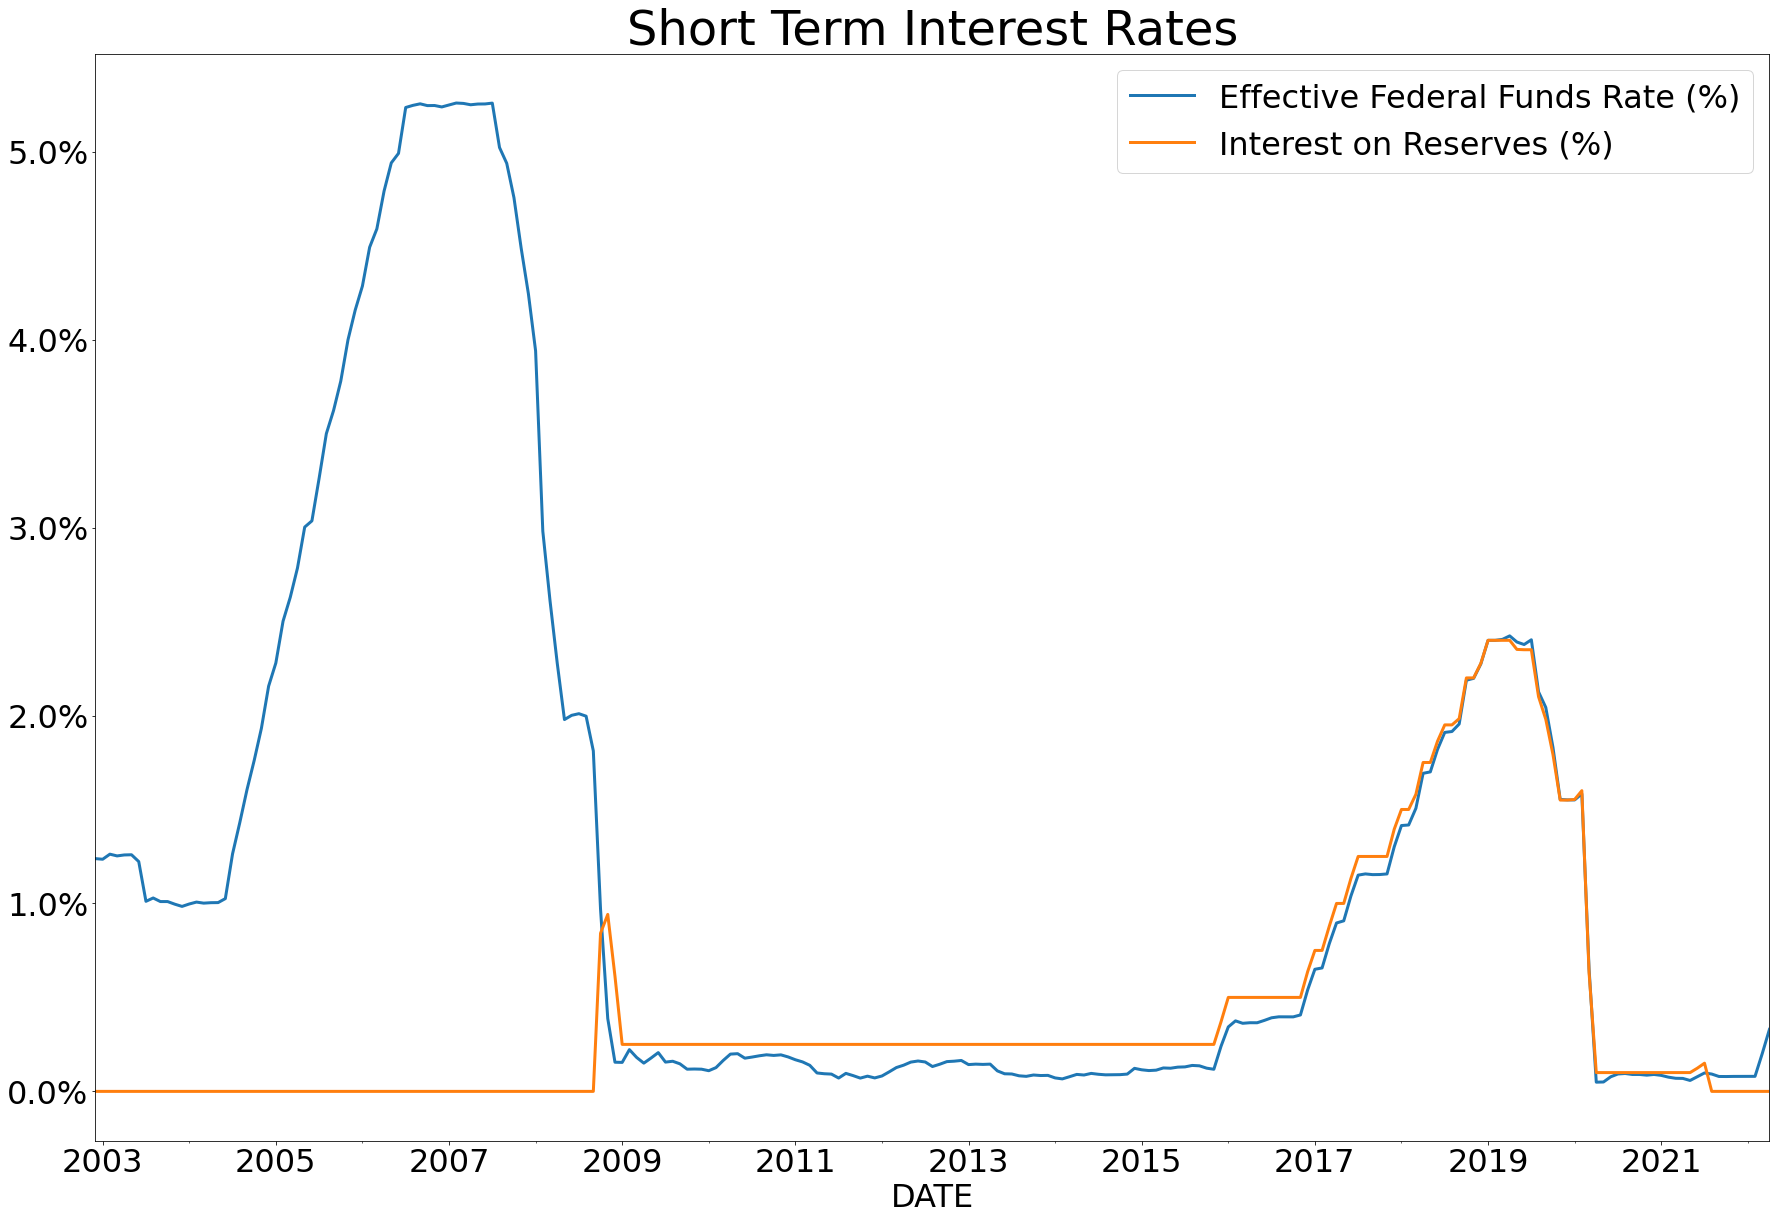

In [5]:
plt.rcParams.update({"font.size":32})
interest_vars = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)"]
fig, ax = plt.subplots(figsize = (30,20))
data[interest_vars].plot.line(legend=True, linewidth = 3, ax = ax)
y_vals = ax.get_yticks()
ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])  
ax.set_title("Short Term Interest Rates", fontsize = 48)
data[["Date"] + interest_vars].to_json("shortTermRates.json", orient="records")

In [6]:
# data = data.rename(columns = {
#     key: key.replace("Balance Sheet: ", "").replace(" ($ Mil)", "").replace("Base: ","") for key in data.keys()})
keys = list(data.keys())
interest_rates = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)",
                   "1 Month Treasury Rate (%)"]
plot_data = data.copy()
for key, val in data.items():
    if key not in interest_rates:
        try:
            plot_data[key] = val.div(10**6)
        except:
            continue

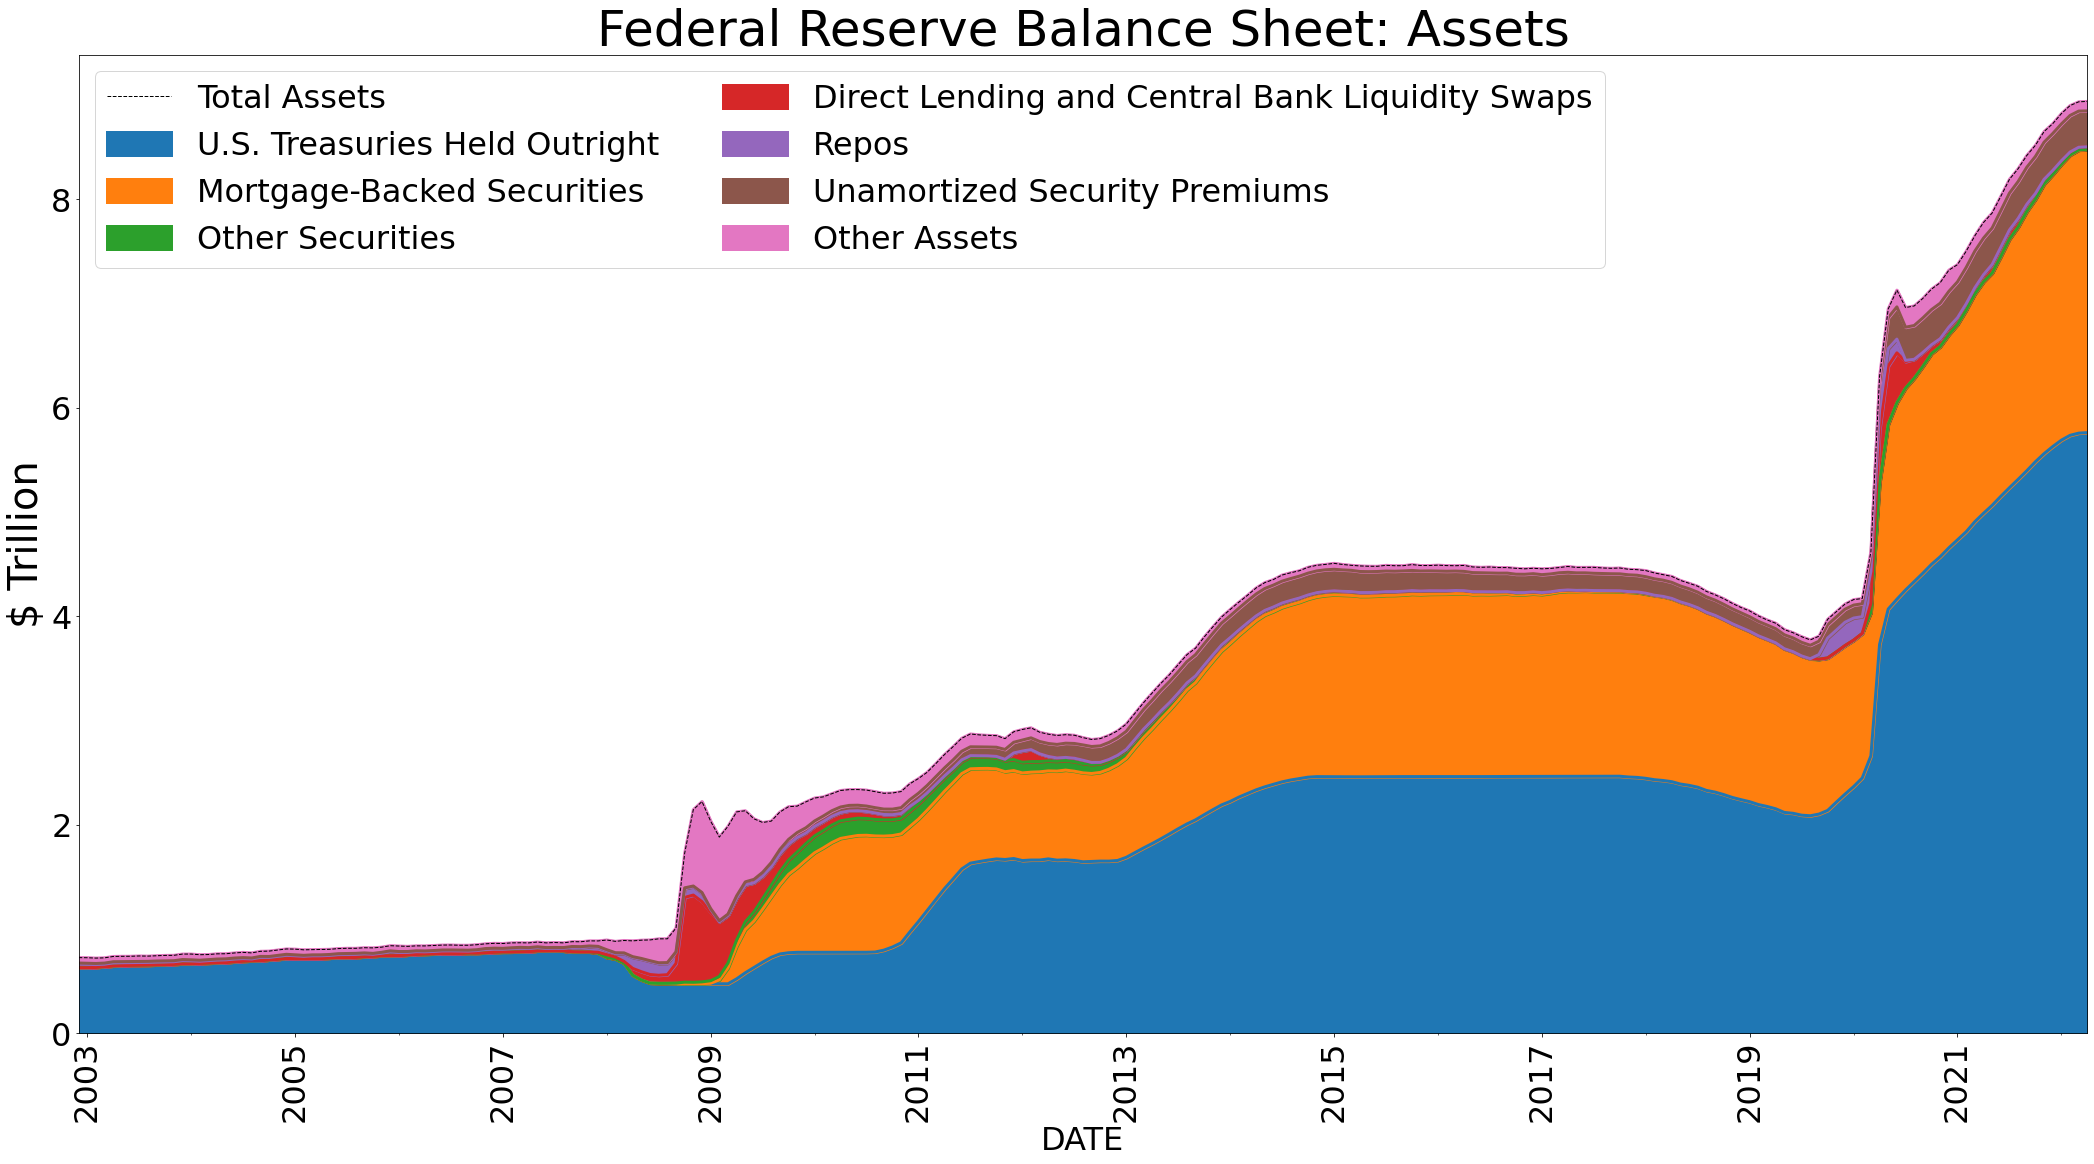

In [7]:
account_vars = ["U.S. Treasuries Held Outright",
               "Mortgage-Backed Securities",
               "Other Securities",
               "Direct Lending and Central Bank Liquidity Swaps",
               "Repos",
               "Unamortized Security Premiums",
               "Other Assets"]
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Assets"
plot_data[total_var].plot.line(linewidth = 1, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Assets", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveAssets.csv")
plot_data[["Date"] + account_vars].to_json("fedAssets.json", orient = "records")

<ipython-input-8-6bfaf211e300>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)


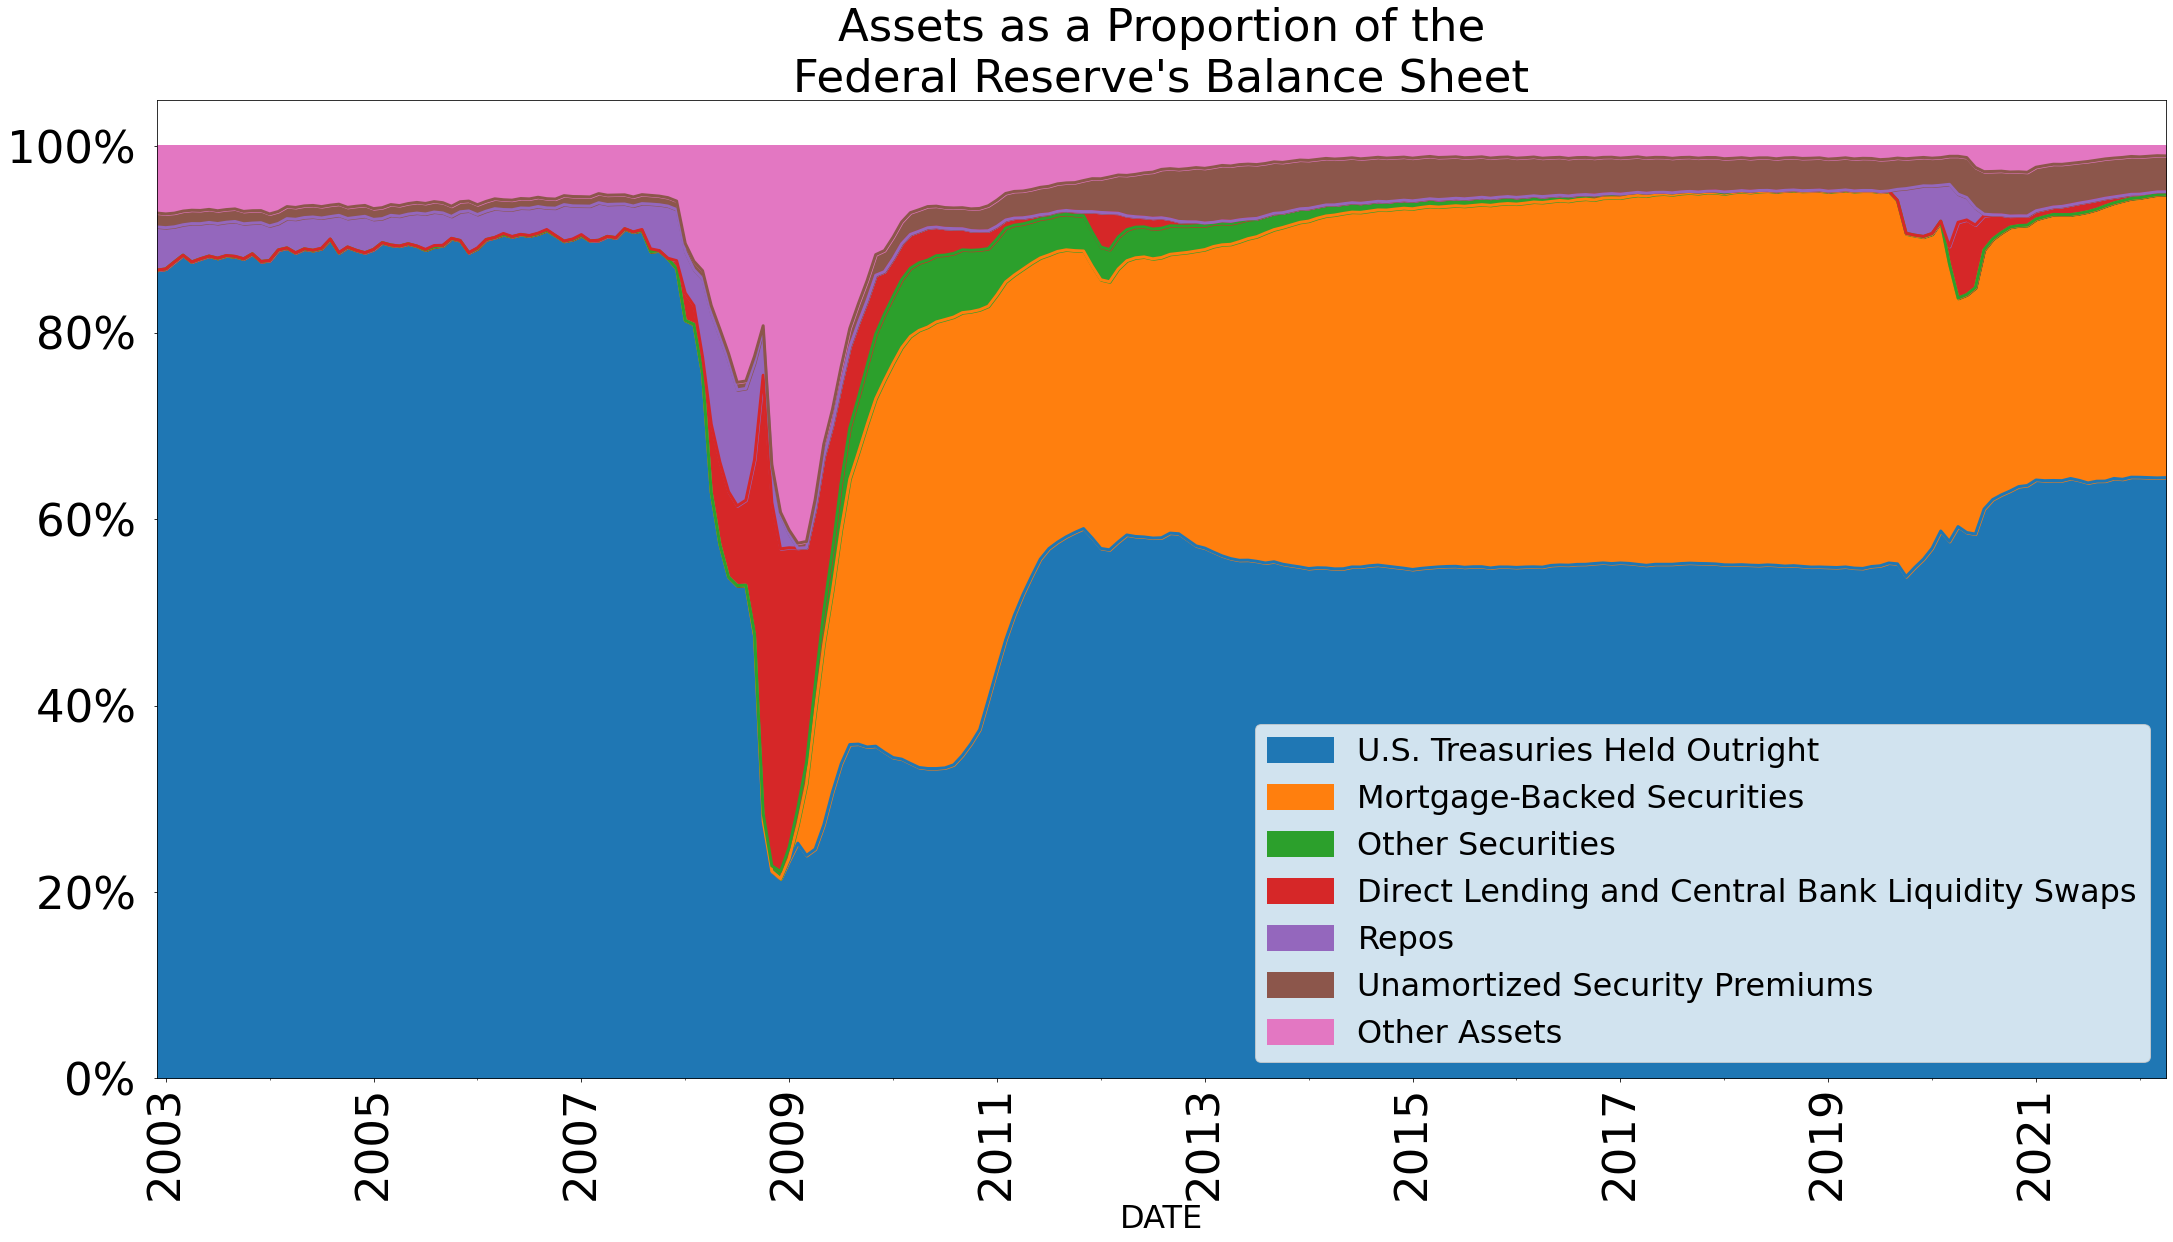

In [8]:
plt.rcParams.update({"font.size":32})
df = plot_data.copy()
for key in account_vars:
    df[key] = df[key].div(df["Total Assets"])
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
df[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
plt.xticks(rotation= 90, fontsize = 45)
ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)

#plt.yticks([int(tick * 100) for tick in ax.get_yticks() if tick <1.01])
plt.title("Assets as a Proportion of the\nFederal Reserve's Balance Sheet", fontsize =45)
plt.show()


<AxesSubplot:xlabel='DATE'>

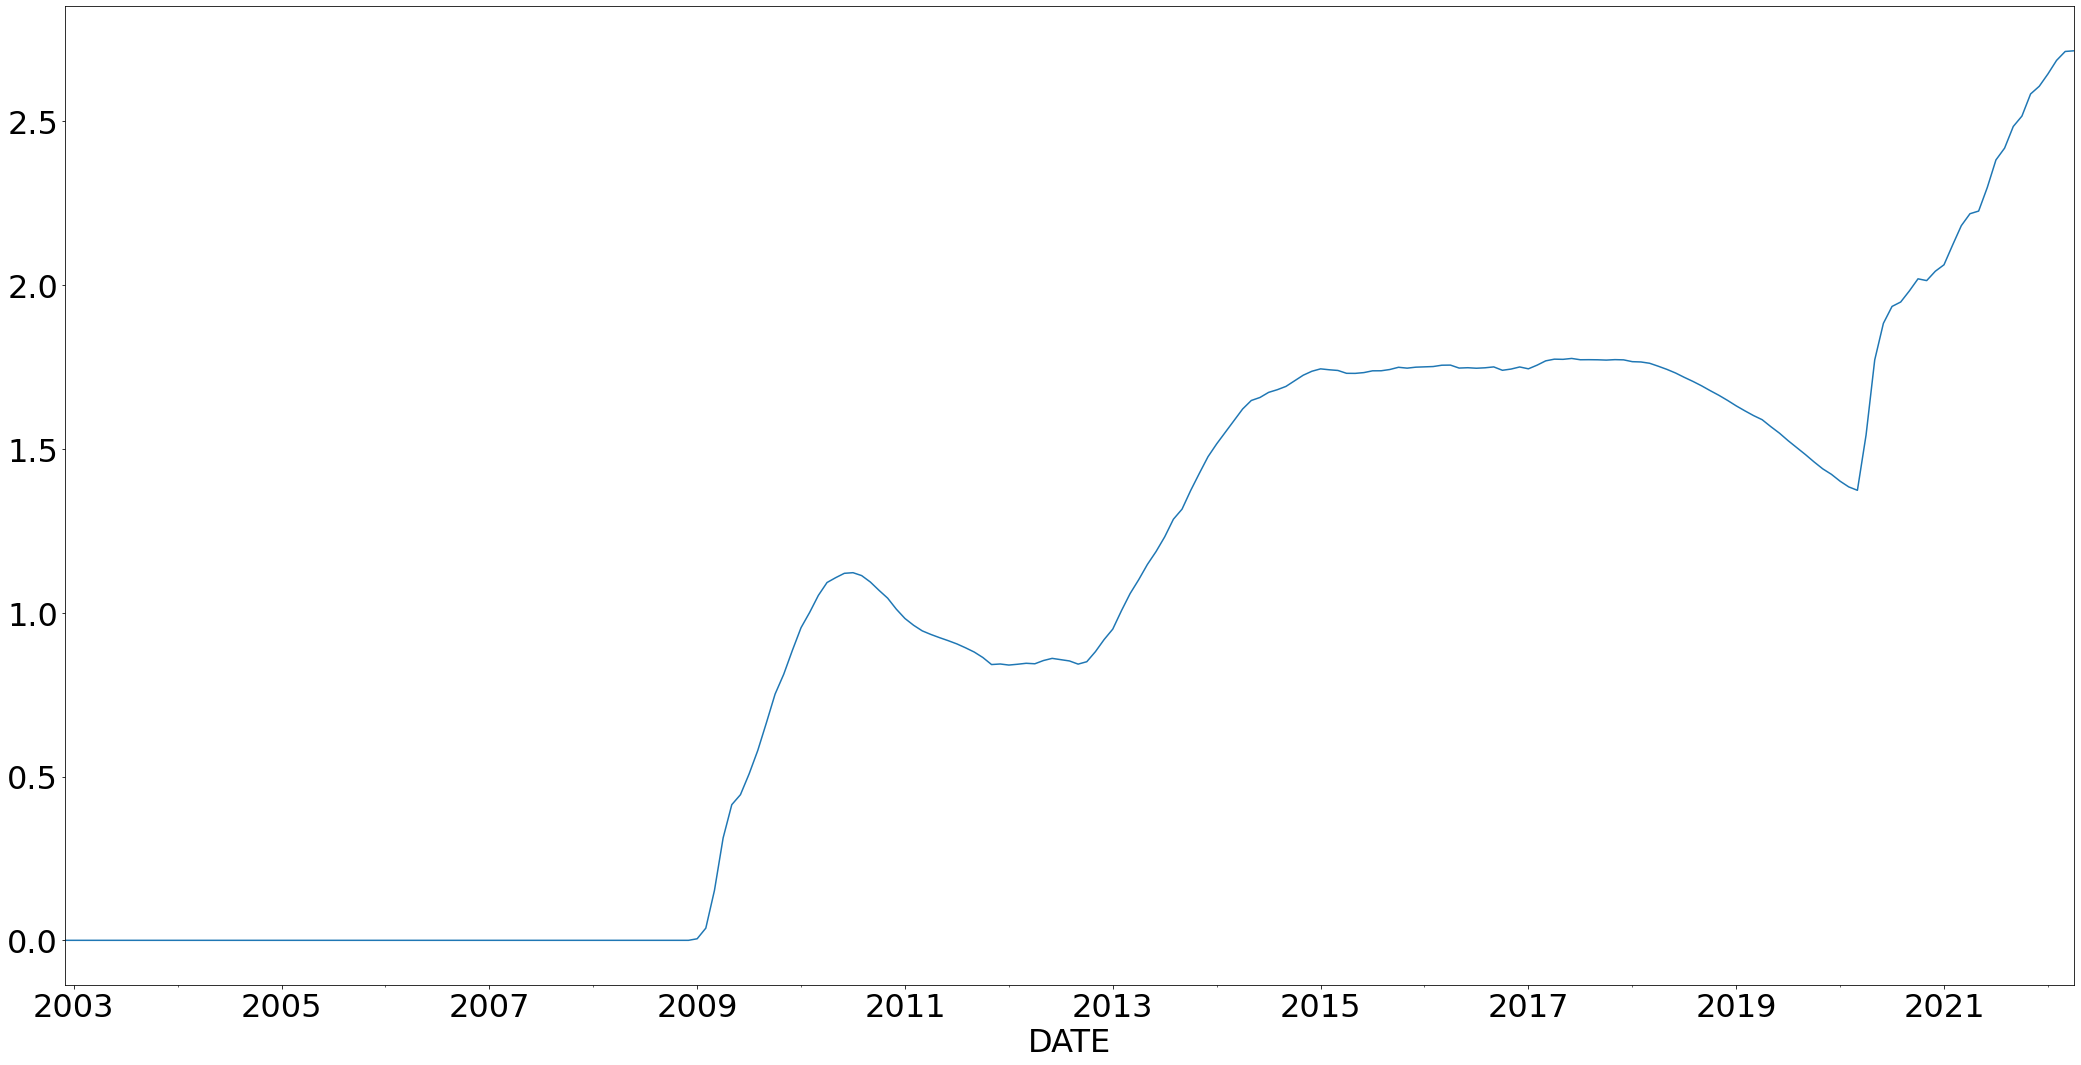

In [9]:
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)

plot_data["Mortgage-Backed Securities"].plot.line(ax = ax)

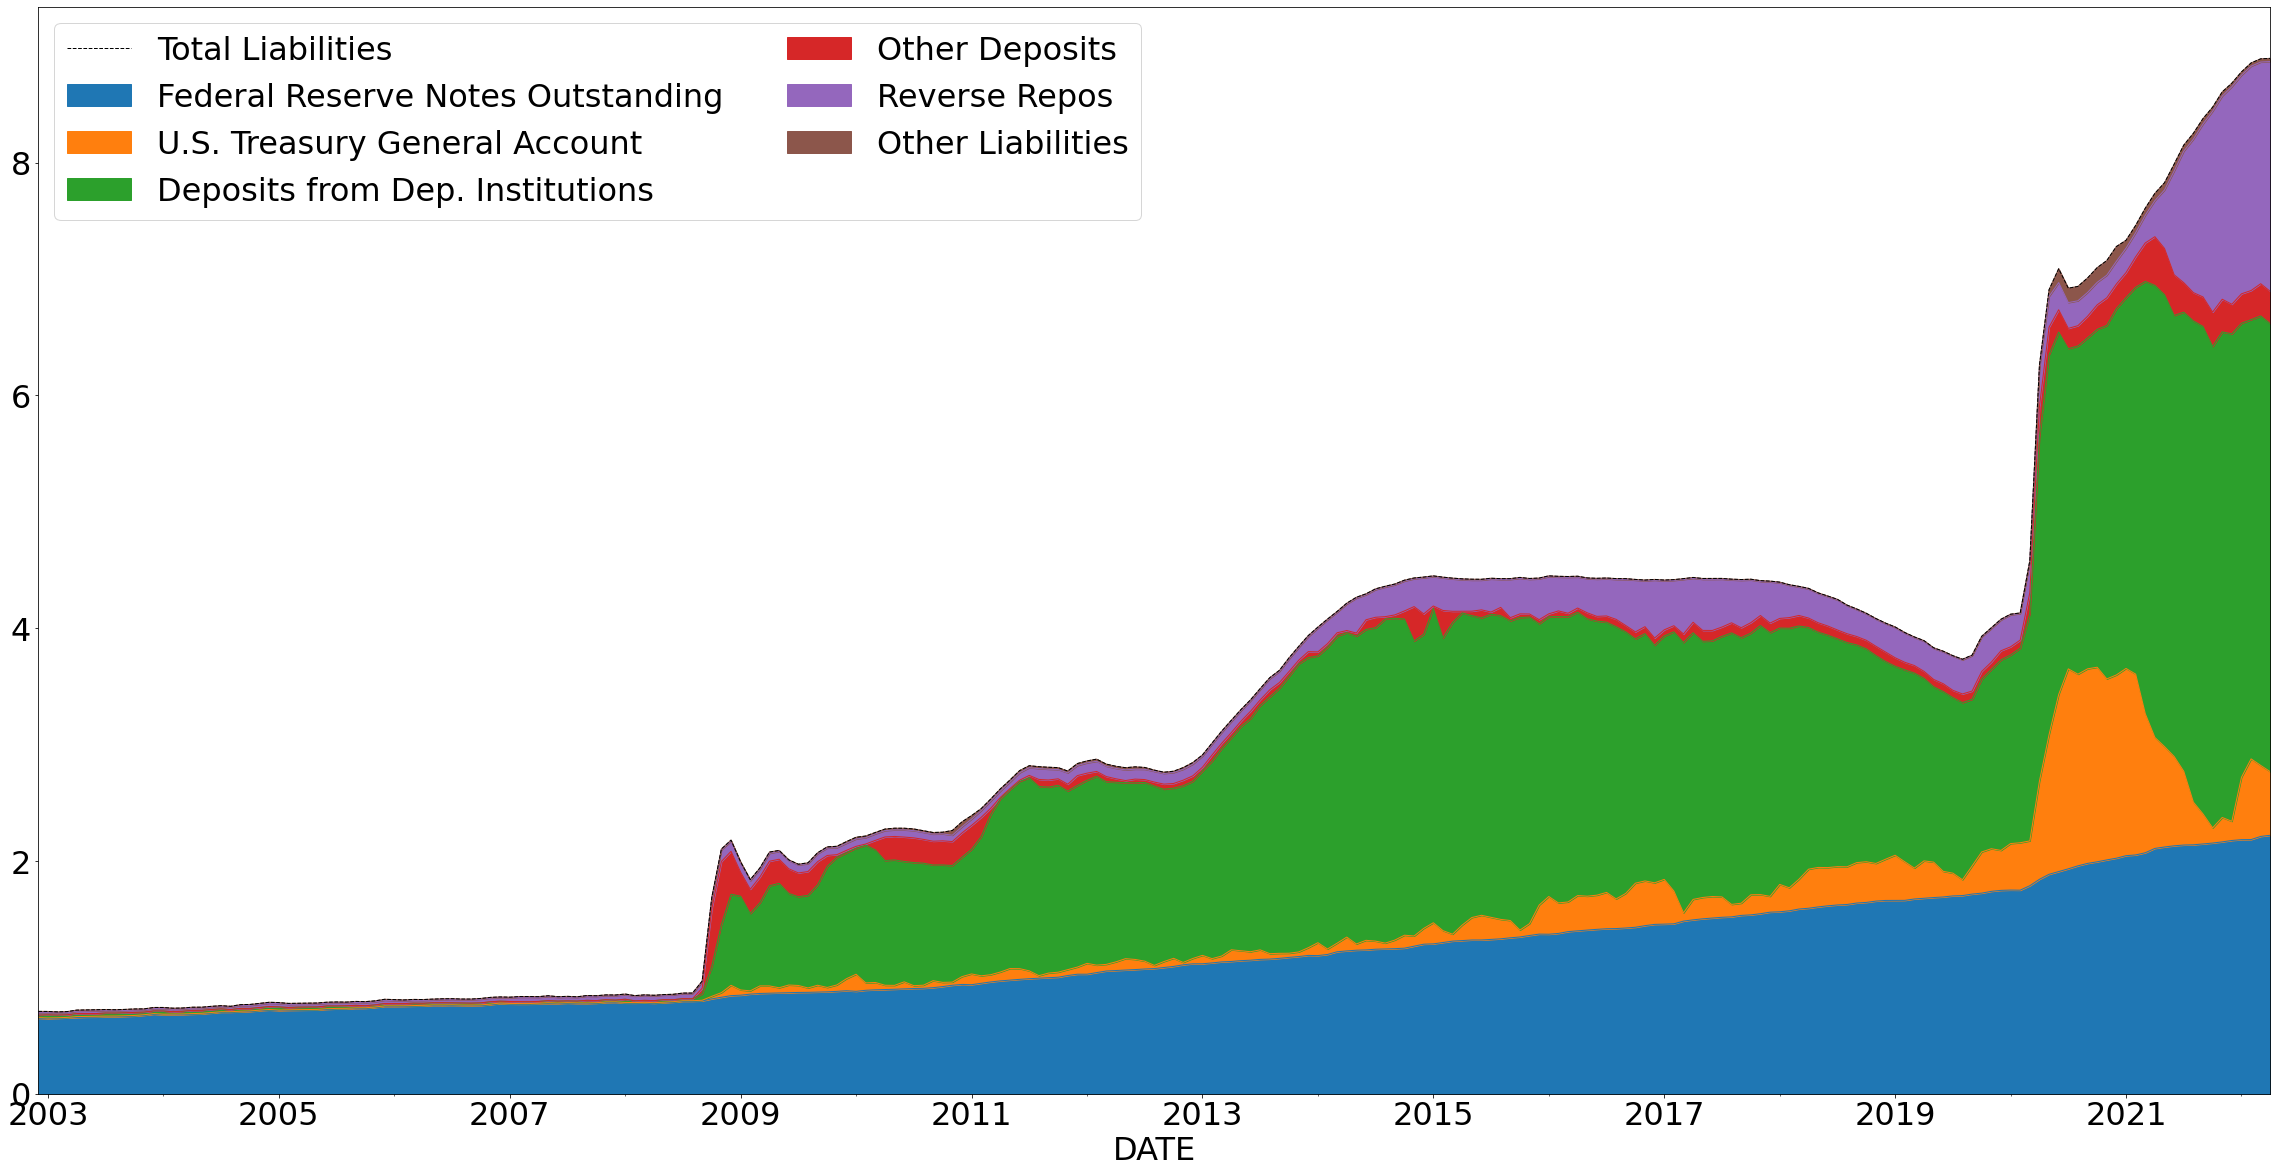

In [10]:
account_vars = ["Federal Reserve Notes Outstanding",
                "U.S. Treasury General Account",
                "Deposits from Dep. Institutions",
                "Other Deposits",
                "Reverse Repos",
                "Other Liabilities"]
total_var = "Total Liabilities"

plot_stacked_lines(
    plot_data,
    account_vars, linewidth = 1,
    total_var = "Total Liabilities")


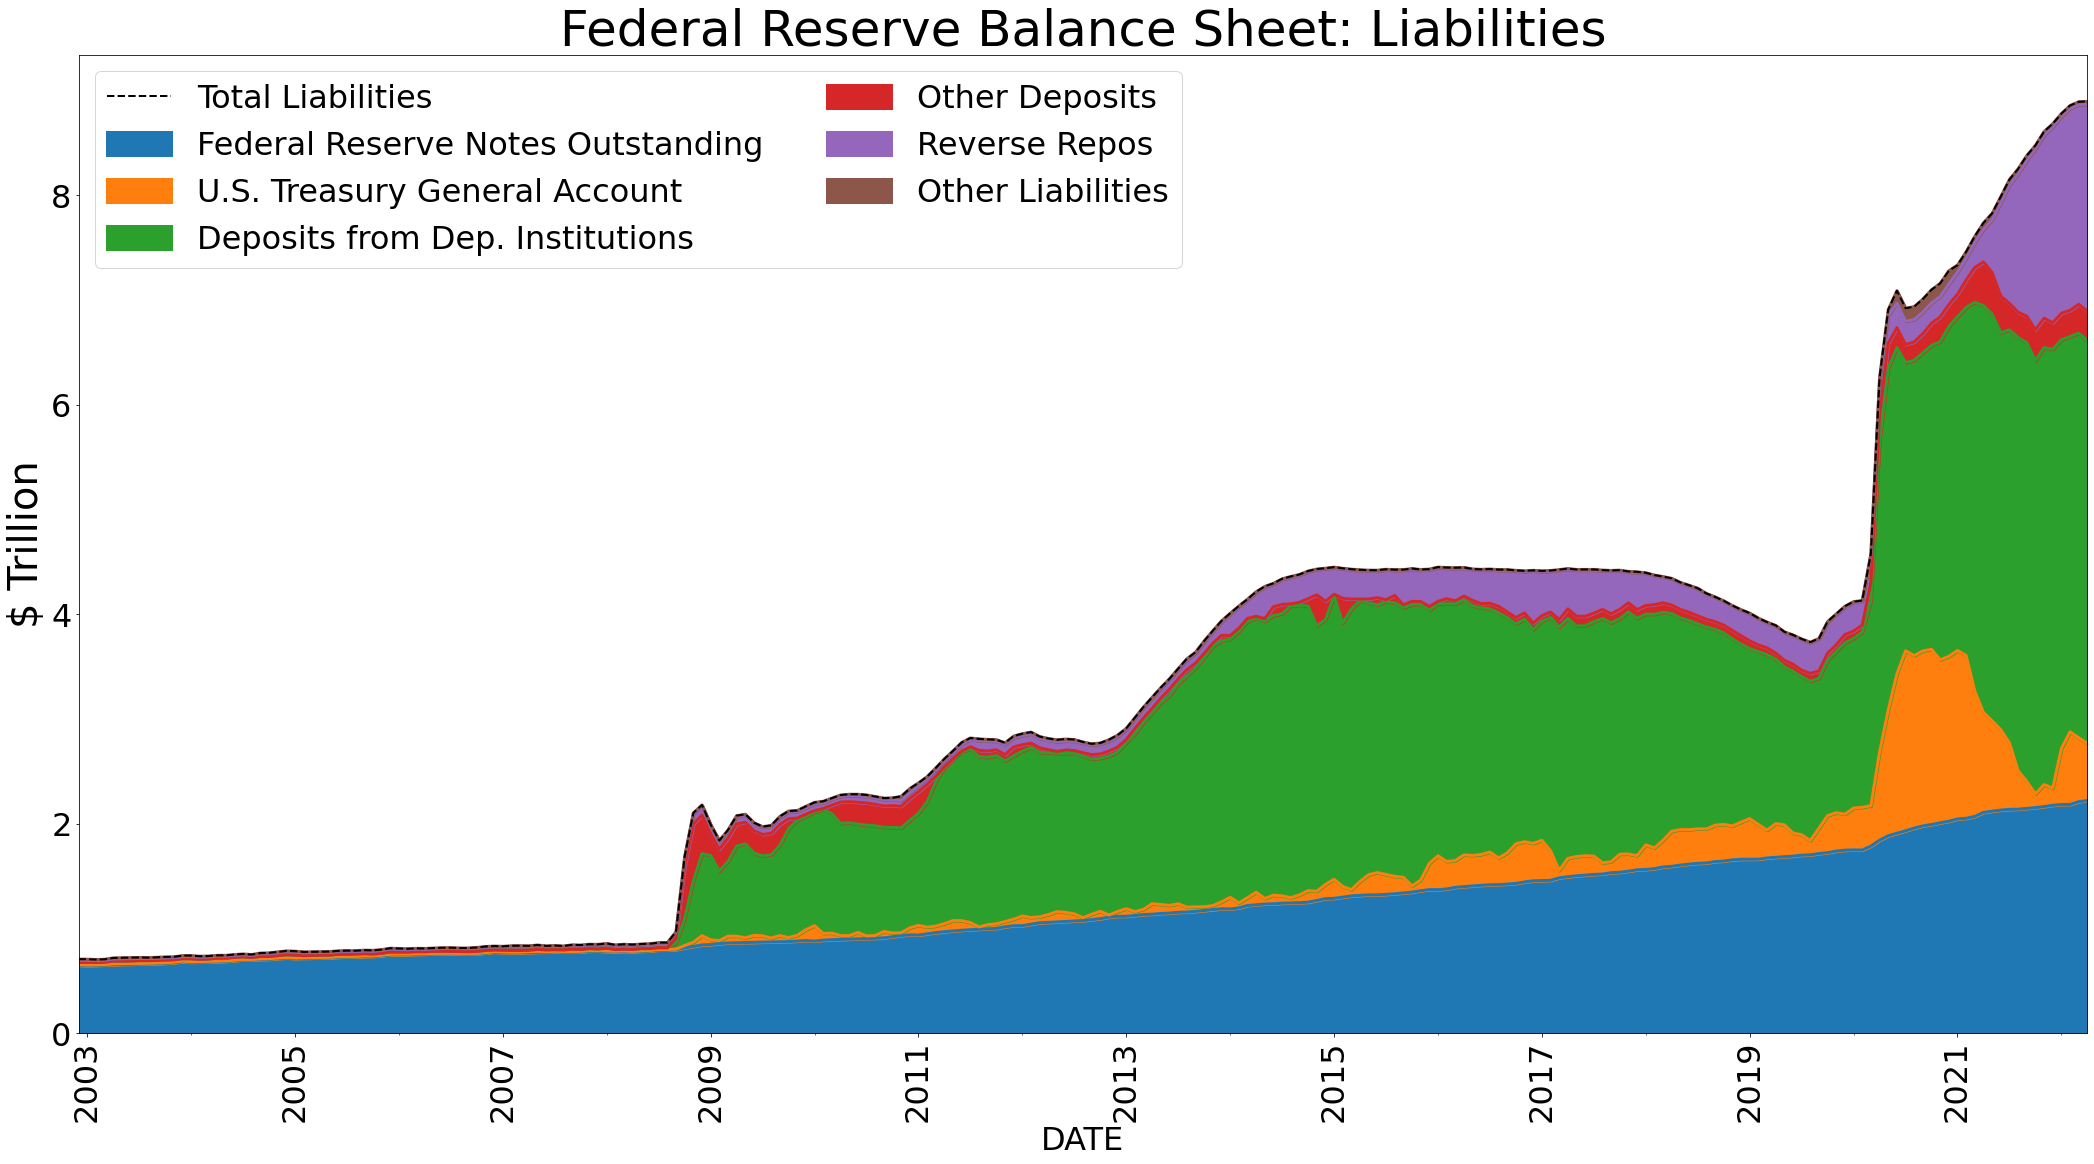

In [11]:
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Liabilities"
plot_data[total_var].plot.line(linewidth = 2, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Liabilities", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveLiabilities.csv")

<ipython-input-12-bd89c59b9c46>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)


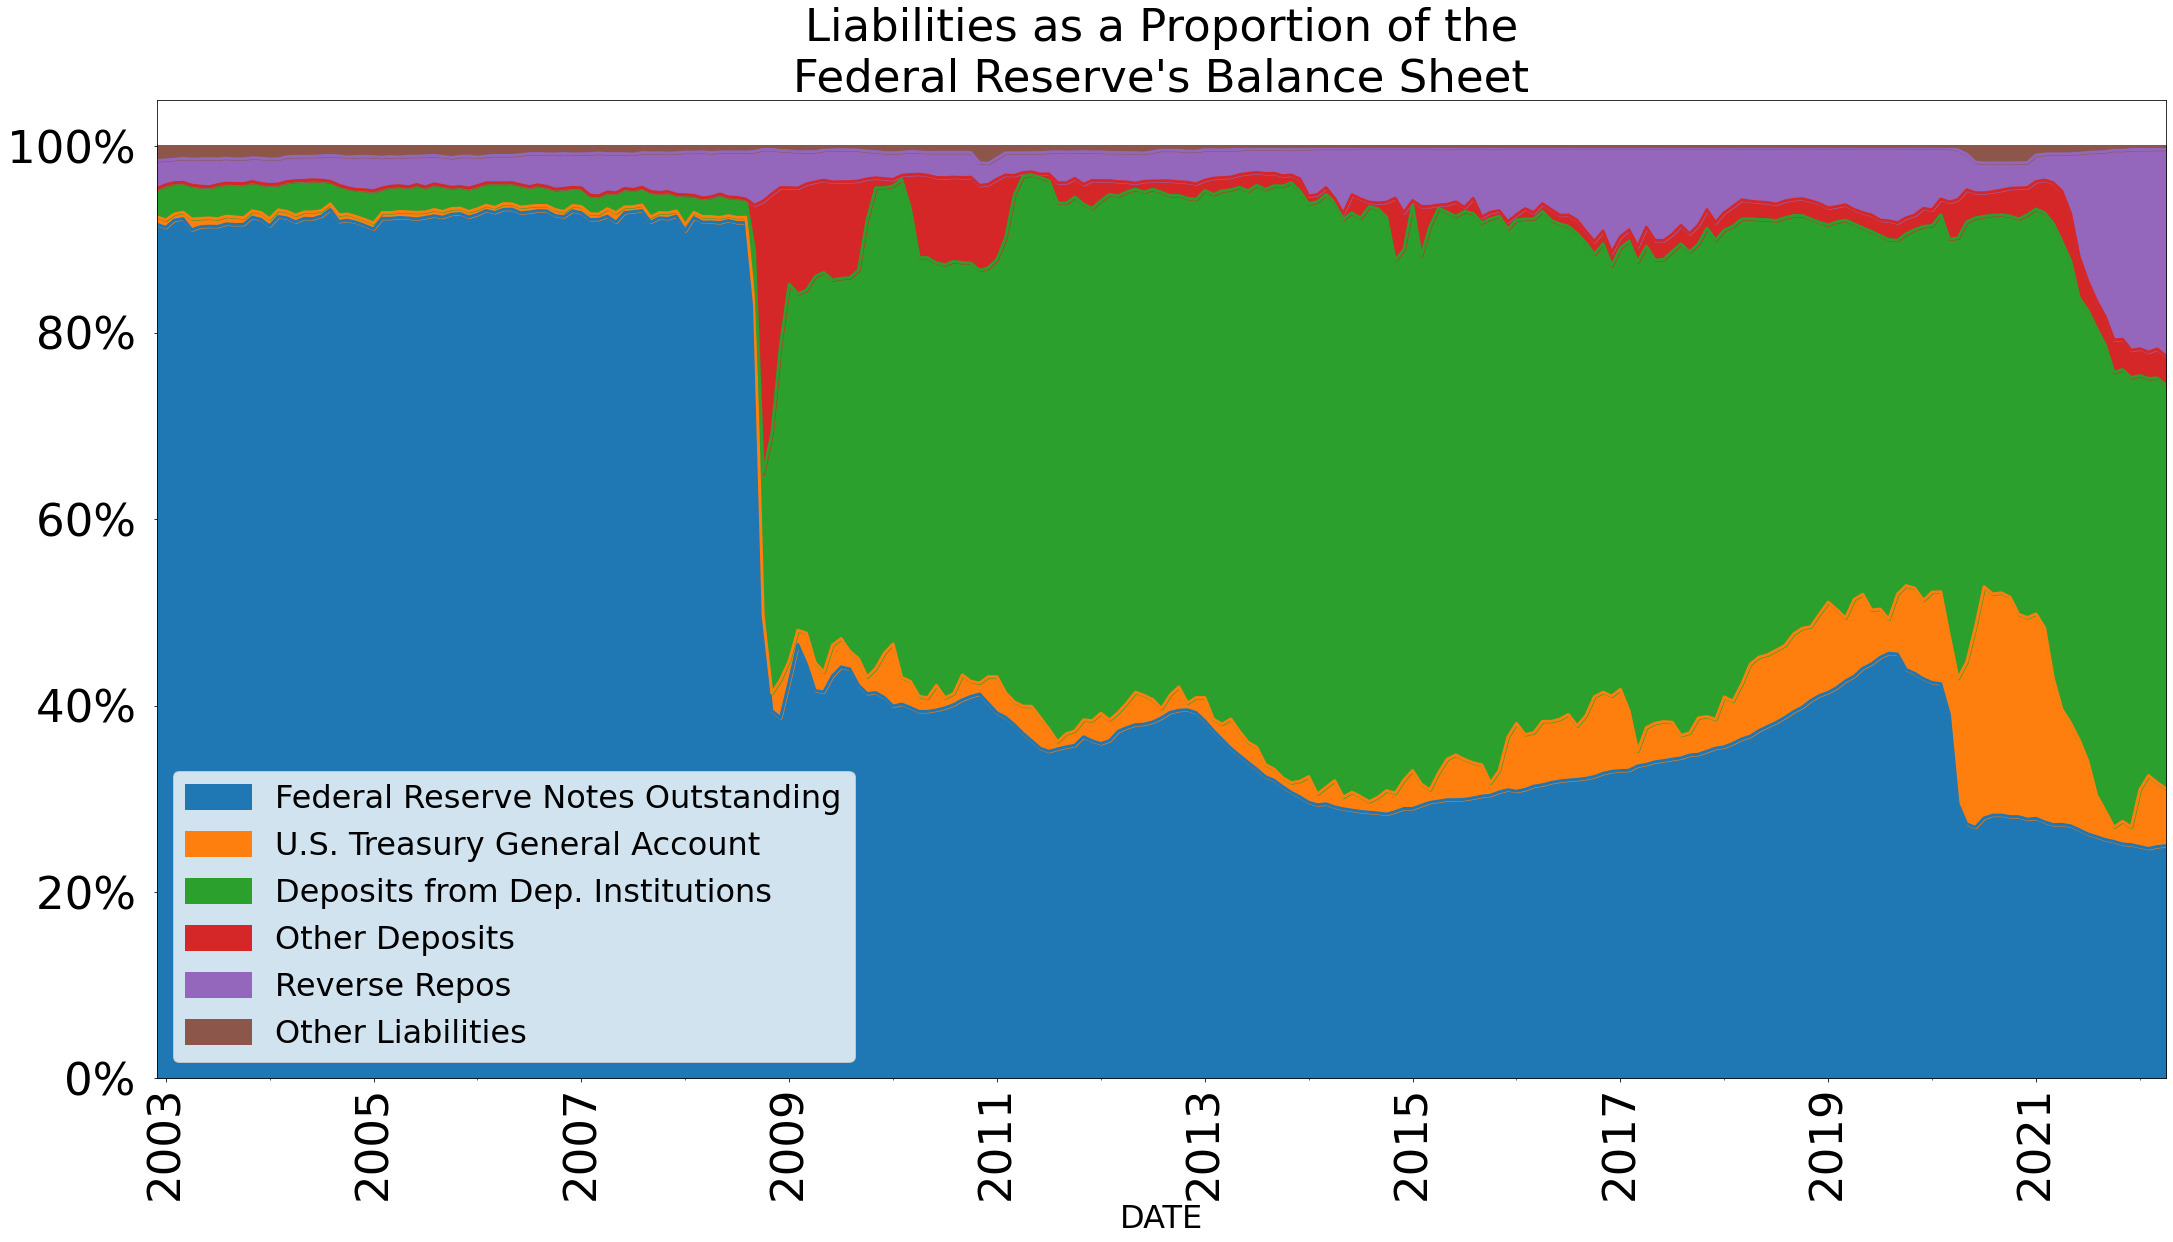

In [12]:
plt.rcParams.update({"font.size":32})
df = plot_data.copy()
for key in account_vars:
    df[key] = df[key].div(df["Total Liabilities"])
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
df[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
plt.xticks(rotation= 90, fontsize = 45)
ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)

#plt.yticks([int(tick * 100) for tick in ax.get_yticks() if tick <1.01])
plt.title("Liabilities as a Proportion of the\nFederal Reserve's Balance Sheet", fontsize =45)
plt.show()


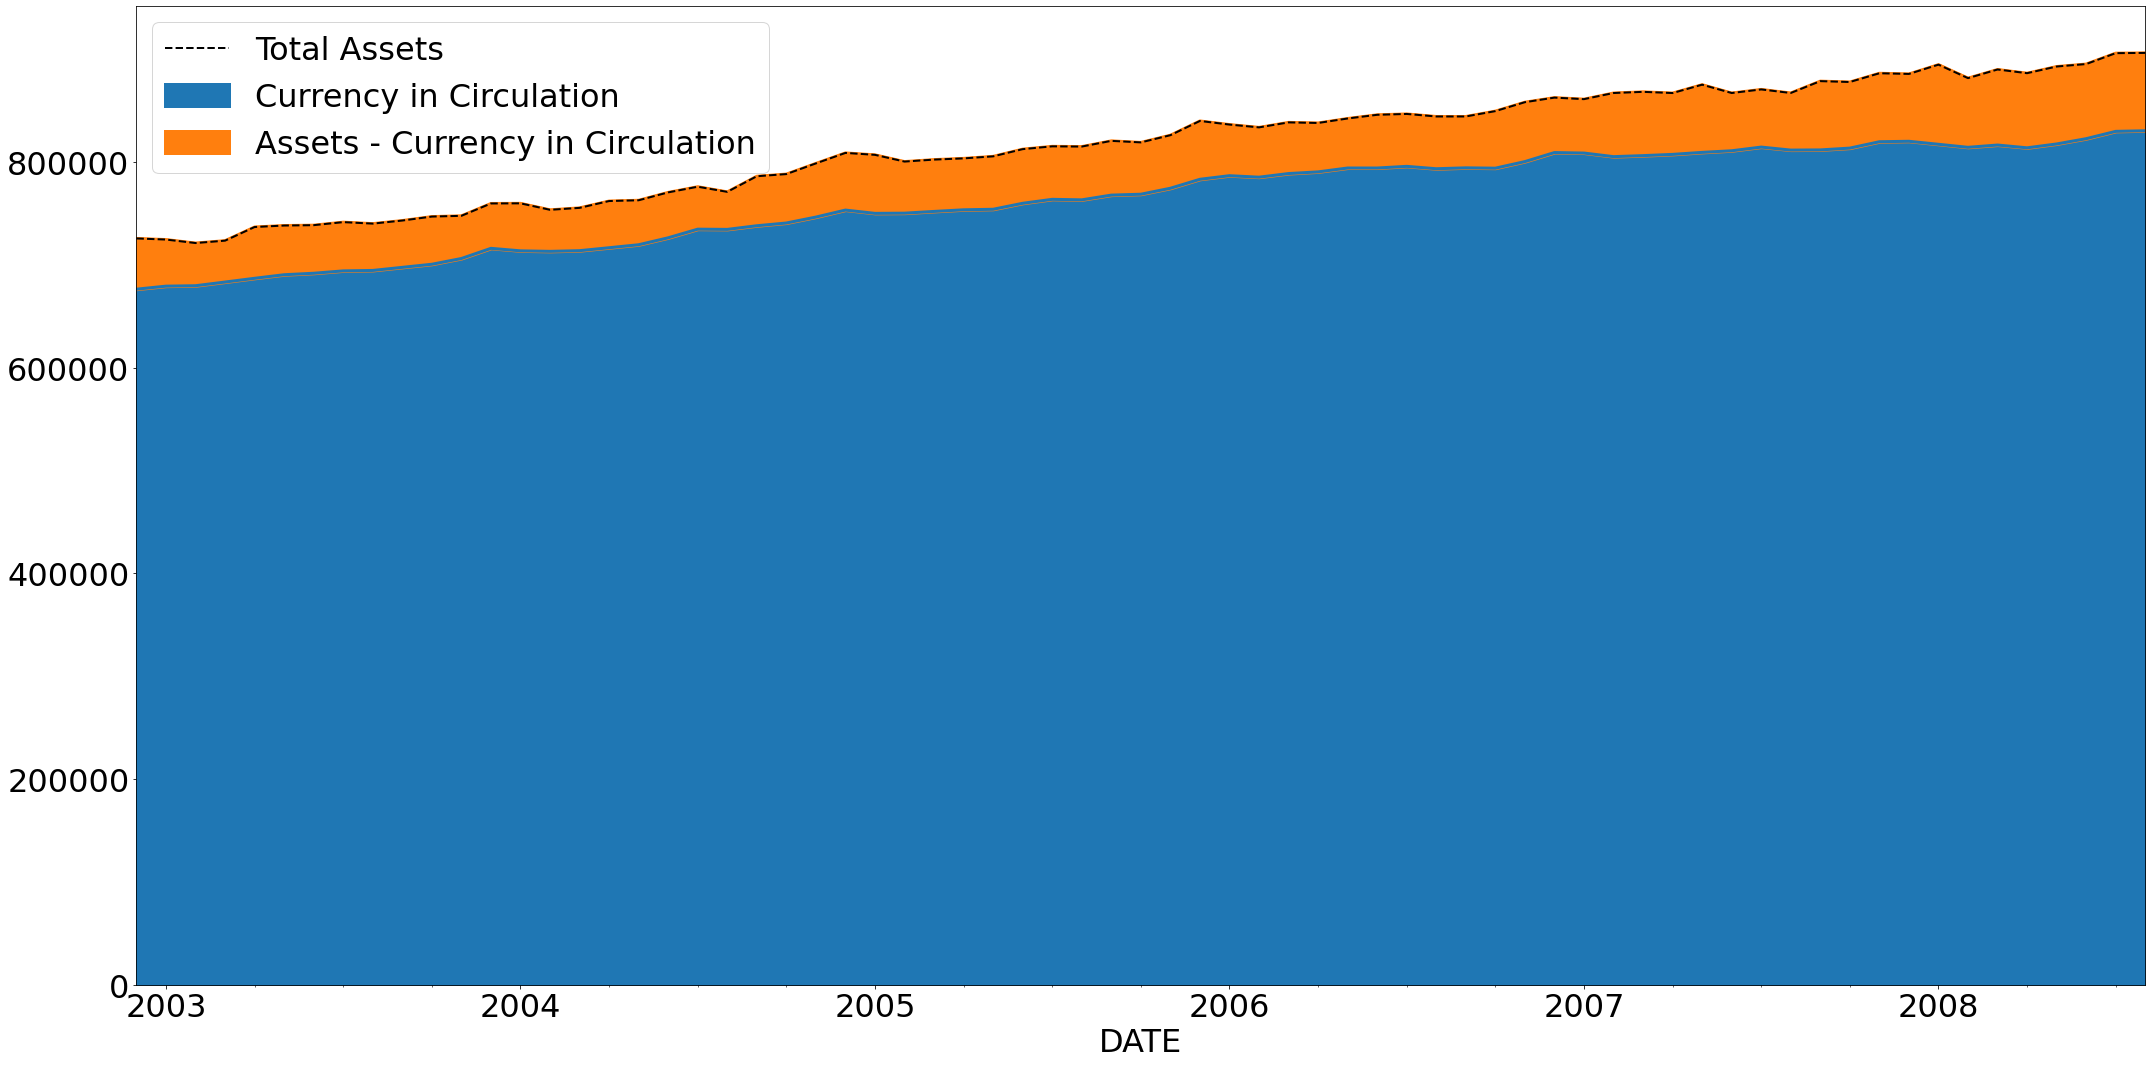

In [13]:
data["Assets - Currency in Circulation"] = data["Total Assets"].sub(data["Currency in Circulation"])
figsize= (36,18)
account_vars = ["Currency in Circulation", "Assets - Currency in Circulation"]
plot_data = data.copy().loc[:"2008-09-01"]
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax, legend = False)
# change y vals from mil to tril
total_var = "Total Assets"
plot_data[total_var].plot.line(linewidth = 2, 
                             ax = ax, c = "k",
                             label = total_var, 
                               ls = "--")
plt.legend()


                                                                            

<ipython-input-14-239e20189e98>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)


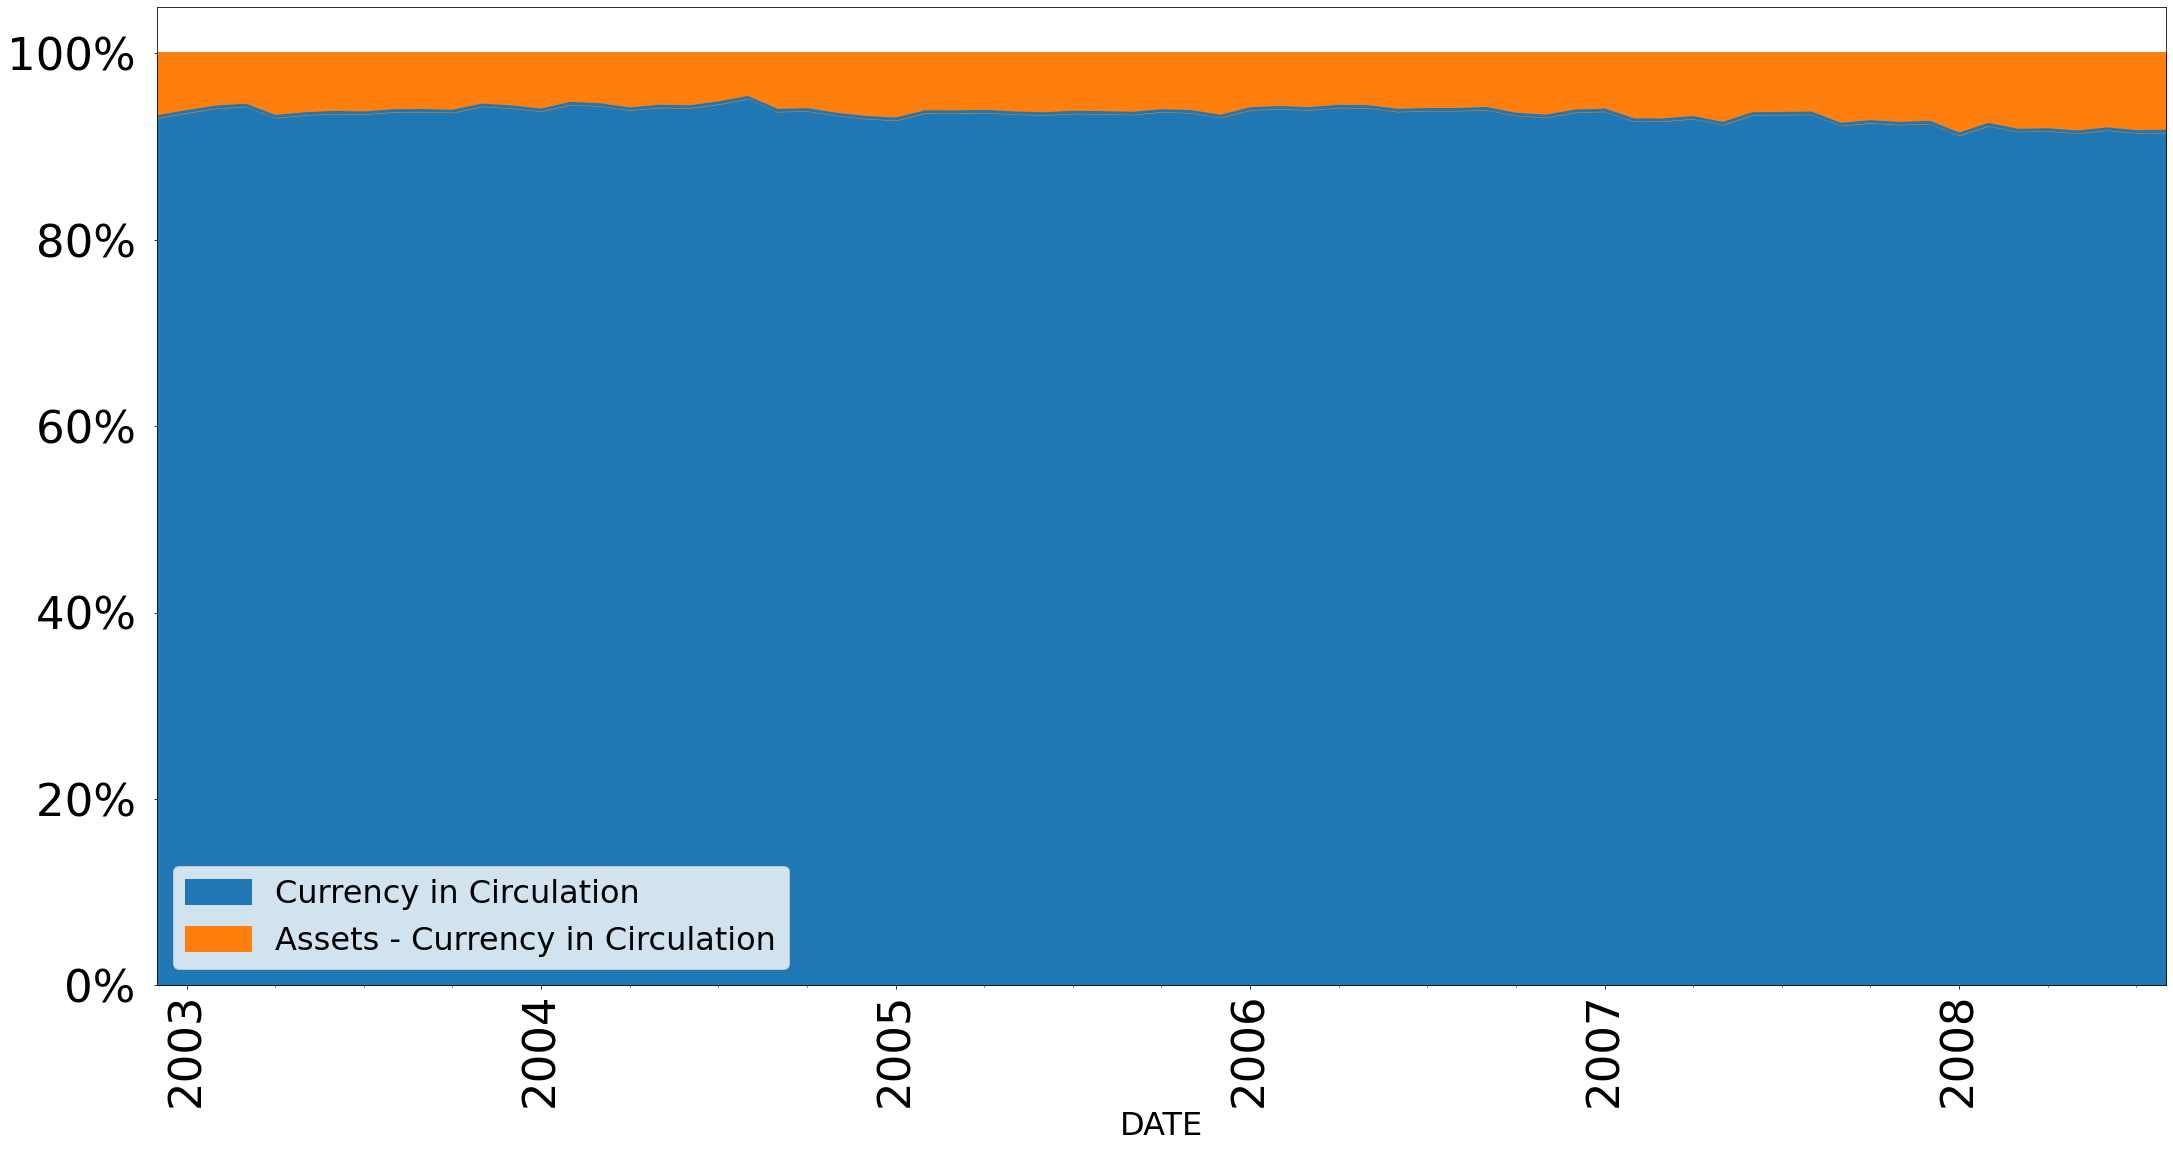

In [14]:
df = plot_data.copy()
for key in account_vars:
    df[key] = df[key].div(df["Total Assets"])
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
df[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
plt.xticks(rotation= 90, fontsize = 45)
ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)

#plt.yticks([int(tick * 100) for tick in ax.get_yticks() if tick <1.01])
plt.show()


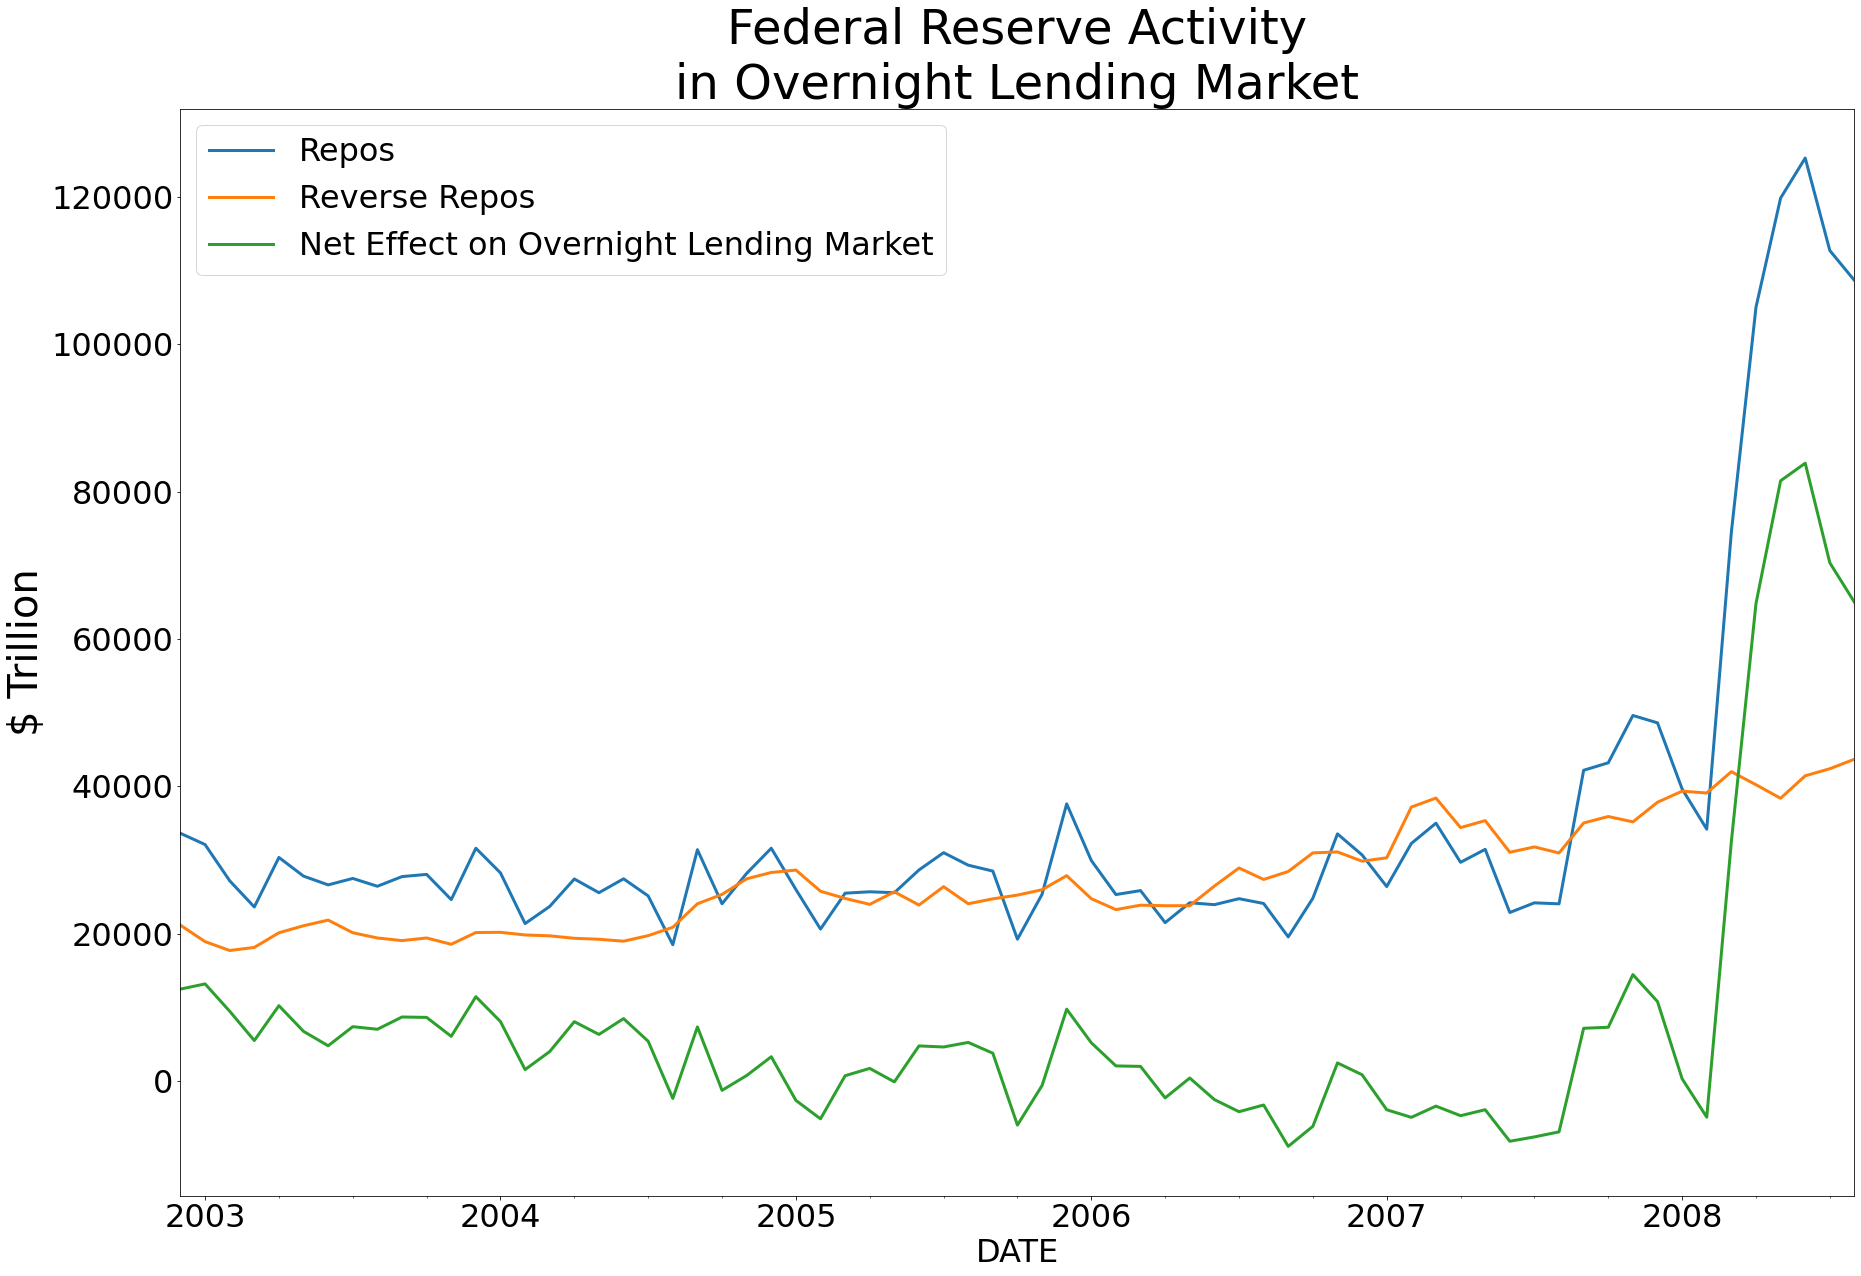

In [15]:
plot_data["Net Effect on Overnight Lending Market"] =\
    plot_data["Repos"].sub(plot_data["Reverse Repos"])
overnight_vars = ["Repos",
                  "Reverse Repos",
                  "Net Effect on Overnight Lending Market"]
fig, ax = plt.subplots(figsize = (30,20))
plot_data[overnight_vars].plot.line(legend=True, linewidth = 3, ax = ax)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Activity\nin Overnight Lending Market", fontsize = 48)
plot_data[["Date"] + overnight_vars].to_json("overnightLending.json", orient="records")


<ipython-input-16-e45b2ab256d4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val )) + "%" for val in ax.get_yticks()], c = "C0")
<ipython-input-16-e45b2ab256d4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
<ipython-input-16-e45b2ab256d4>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")


Text(0.5, 0, '')

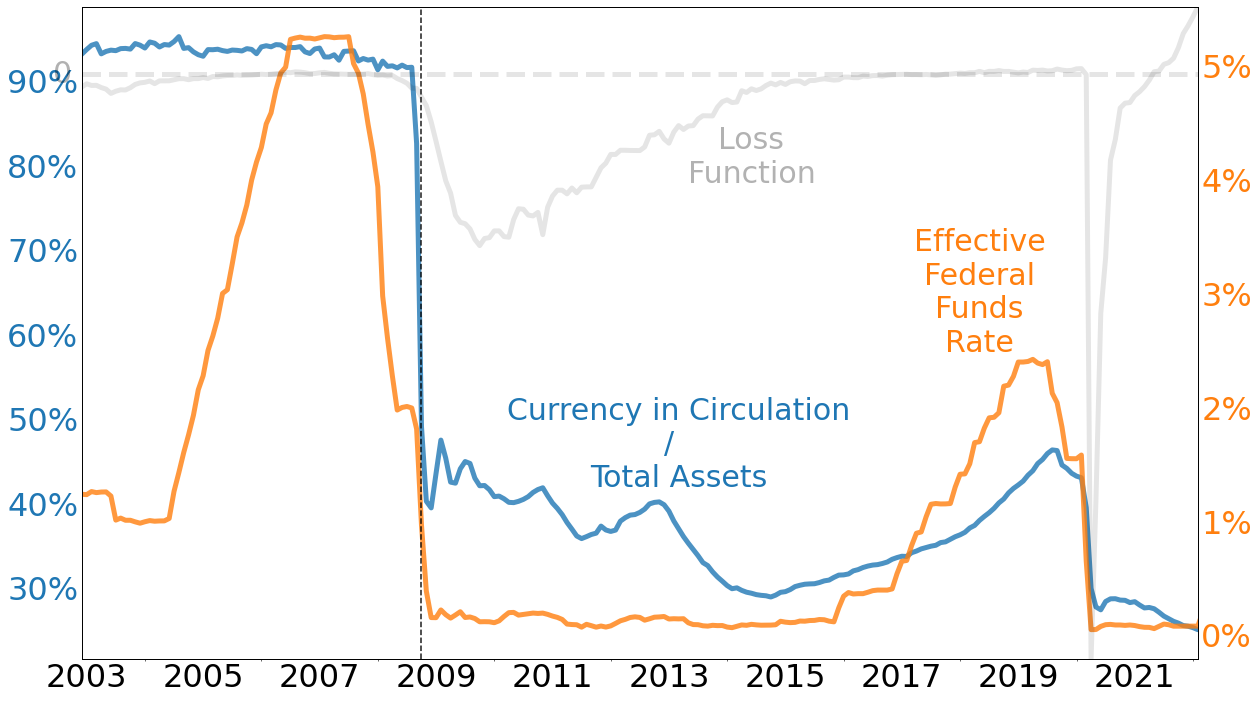

In [16]:
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)

data[["Currency in Circulation / Total Assets"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)
ax.tick_params(length = 0)
ax2 = ax.twinx()
ax3 = ax.twinx()
ax2.tick_params(length = 0)
ax3.tick_params(length = 0)

data[["Effective Federal Funds Rate (%)"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax2,
                                                        c = "C1")
data[["Loss Function"]].dropna().plot(legend = False, 
                                       linewidth = 5, 
                                       alpha = .1,
                                       ax = ax3,
                                       c = "k")

ax.set_yticklabels([str(int(val )) + "%" for val in ax.get_yticks()], c = "C0")
ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")
ax3.set_yticks([])
ax3.set_ymargin(0)

ax3.axhline(0, c = "k", alpha = .1, linewidth = 5, ls = "--")
plt.xticks(rotation = 90)

plt.axvline(datetime.datetime(2008,10,1), c = "k", ls = "--", alpha = .9)
ax.text(datetime.datetime(2013,3,1), 42, "Currency in Circulation\n/  \nTotal Assets", fontsize = 30, c = "C0", 
        ha = "center")
ax.text(datetime.datetime(2018,5,1), 58, "Effective\nFederal\nFunds\nRate", fontsize = 30, c = "C1", 
        ha = "center")
ax.text(datetime.datetime(2014,6,1), 78, "Loss\nFunction", fontsize = 30, c = "k", alpha = .3, 
        ha = "center")
ax3.text(datetime.datetime(2002,10,10), 0, "0", fontsize = 30, c = "k", alpha = .3, 
        ha = "right", va = "center")
ax.set_xlabel("")
# ax.text(datetime.datetime(2021,12,1), 93.5, "0 ", fontsize = 30, c = "k", alpha = .3, 
#         ha = "left")

<ipython-input-17-1af638c65abf>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(val ) + "%" for val in ax.get_yticks()], c = "C0")
<ipython-input-17-1af638c65abf>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")


Text(0.5, 0, '')

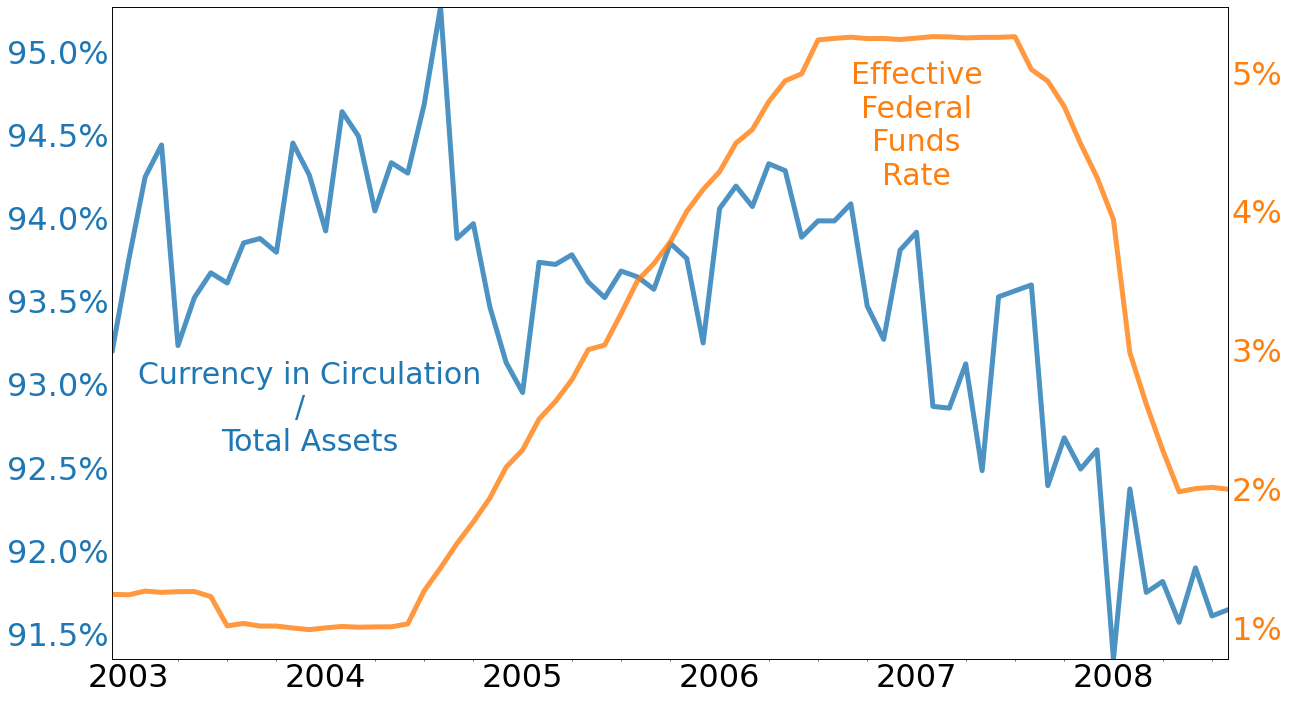

In [17]:
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)
plot_data = data.copy().loc[:"2008-09-01"]
plot_data[["Currency in Circulation / Total Assets"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)
ax.tick_params(length = 0)
ax2 = ax.twinx()
ax2.tick_params(length = 0)

plot_data[["Effective Federal Funds Rate (%)"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax2,
                                                        c = "C1")
ax.set_yticklabels([str(val ) + "%" for val in ax.get_yticks()], c = "C0")
ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
ax.set_ymargin(0)

ax3.axhline(0, c = "k", alpha = .1, linewidth = 5, ls = "--")
plt.xticks(rotation = 90)

plt.axvline(datetime.datetime(2008,10,1), c = "k", ls = "--", alpha = .9)
ax.text(datetime.datetime(2003,12,1), 92.6, "Currency in Circulation\n/  \nTotal Assets", fontsize = 30, c = "C0", 
        ha = "center")
ax.text(datetime.datetime(2007,1,1), 94.2, "Effective\nFederal\nFunds\nRate", fontsize = 30, c = "C1", 
        ha = "center")
ax.set_xlabel("")
# ax.text(datetime.datetime(2021,12,1), 93.5, "0 ", fontsize = 30, c = "k", alpha = .3, 
#         ha = "left")

In [18]:
list(data.keys())

['Total Assets',
 'Balance Sheet Securities, Prem-Disc, Repos, and Loans',
 'Securities Held Outright',
 'U.S. Treasuries Held Outright',
 'Federal Agency Debt Securities',
 'Mortgage-Backed Securities',
 'Repos',
 'Central Bank Liquidity Swaps',
 'Direct Lending',
 'Unamortized Security Premiums',
 'Total Liabilities',
 'Federal Reserve Notes Outstanding',
 'Reverse Repos',
 'Deposits from Dep. Institutions',
 'U.S. Treasury General Account',
 'Other Deposits',
 'All Deposits',
 'Total Capital',
 'Unemployment Rate',
 'Nominal GDP ($ Bil)',
 'Real GDP ($ Bil)',
 'GDP Deflator',
 'CPI',
 'Core PCE',
 'Private Investment',
 'Total',
 'Currency in Circulation ($ Bil)',
 '1 Month Treasury Rate (%)',
 '3 Month Treasury Rate (%)',
 '1 Year Treasury Rate (%)',
 '2 Year Treasury Rate (%)',
 '10 Year Treasury Rate (%)',
 '30 Year Treasury Rate (%)',
 'Effective Federal Funds Rate (%)',
 'Federal Funds Target Rate (Pre-crisis)',
 'Federal Funds Upper Target',
 'Federal Funds Lower Target',
 'In

<ipython-input-19-aaa4398c462e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100 )) + "%" for val in ax.get_yticks()])


Text(0, 0.5, 'Annual Growth Rate')

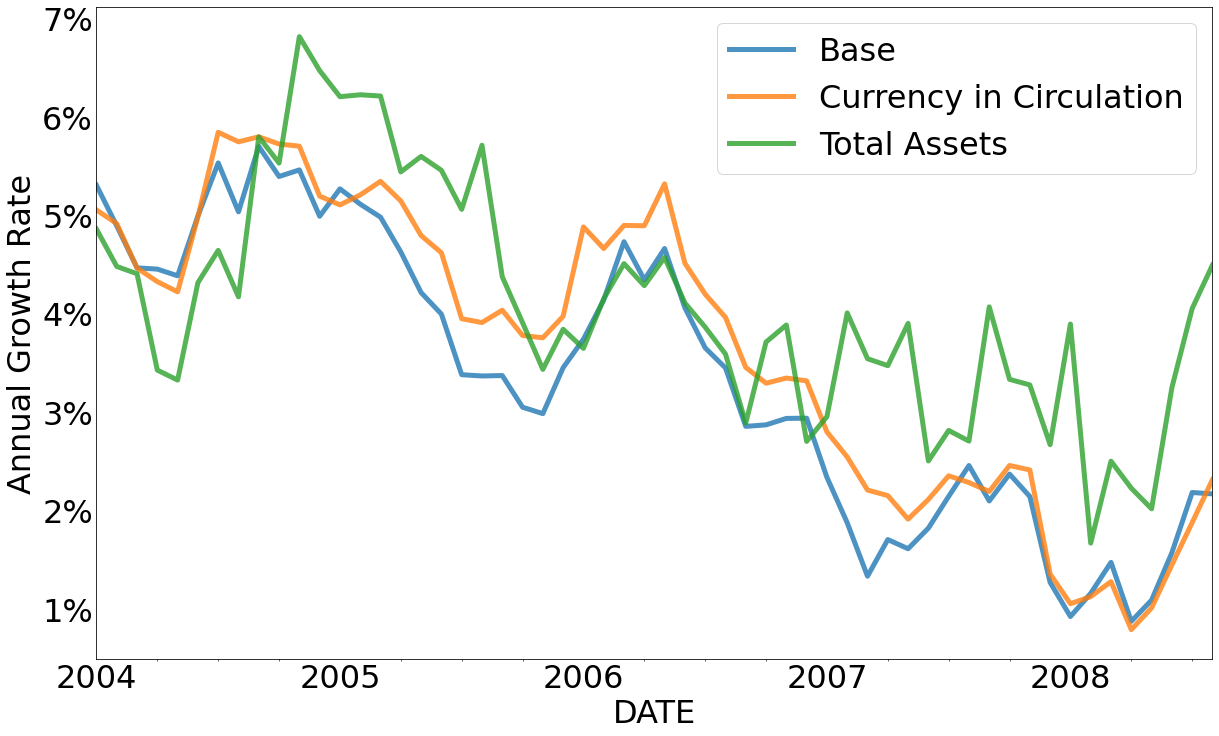

In [19]:
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)
plot_data = data[["Base","Currency in Circulation", "Total Assets"]].pct_change(12).loc["2004":"2008-09-01"]
plot_data.plot(legend = True, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)
ax.tick_params(length = 0)
ax.set_yticklabels([str(int(val * 100 )) + "%" for val in ax.get_yticks()])
ax.set_ylabel("Annual Growth Rate")


<ipython-input-20-d3aa43701cba>:19: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
<ipython-input-20-d3aa43701cba>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(val ) + "%" for val in ax.get_xticks()])
<ipython-input-20-d3aa43701cba>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(val ) + "%" for val in ax.get_yticks()])


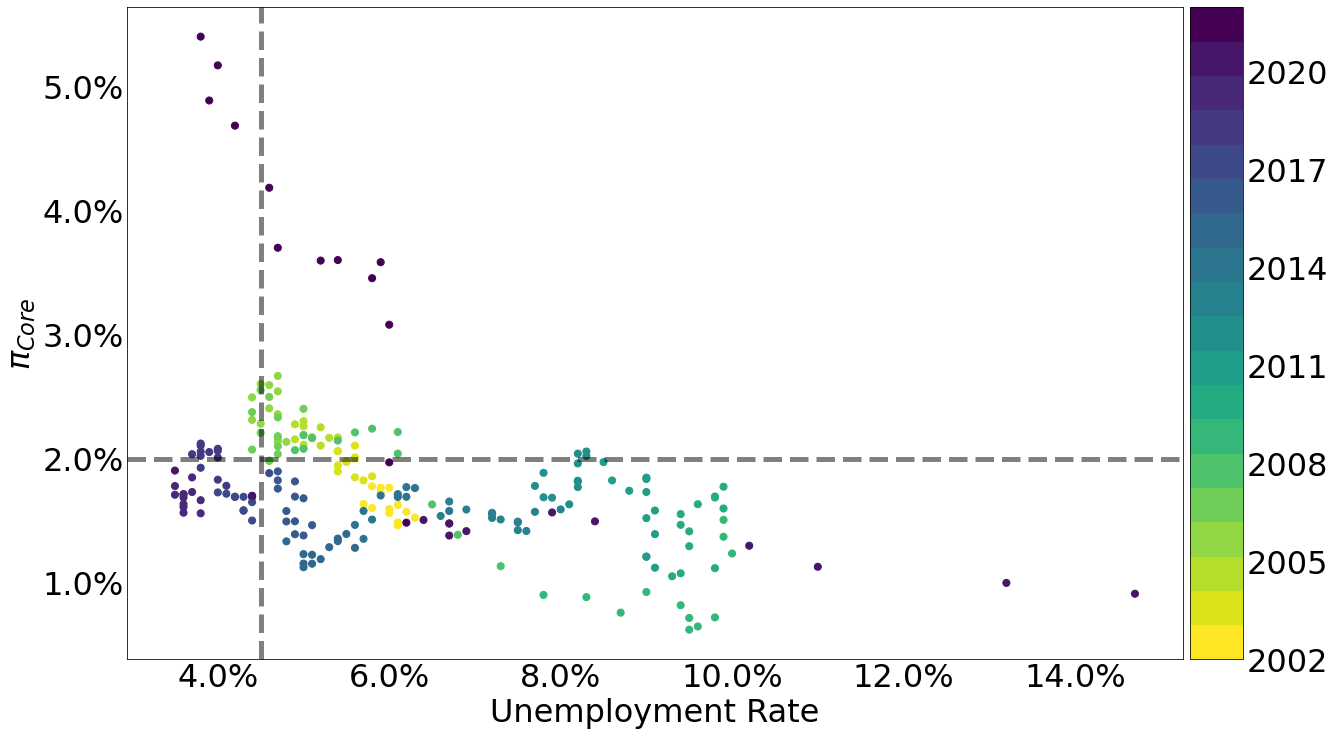

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
x,y,c = "Unemployment Rate", "Inflation (PCE)", "Date"
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)
data["Date"] = data.index
cmap = cm.get_cmap('viridis_r', 19)
# format colormap
vmin, vmax = int(str(data[c][0])[:4]), int(str(data[c][-1])[:4])
norm = cm.colors.Normalize(vmin = vmin, vmax= vmax)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# empty array for the data range
sm._A = []
# prepare space for colorbar
divider = make_axes_locatable(ax)
size = "5%" 
cax = divider.append_axes("right", size = size, pad = 0.1)
# add colorbar to figure
cbar = fig.colorbar(sm, cax=cax, cmap = cmap)
cbar.set_ticks([year for year in range(vmin, vmax +1, 3)])
cbar.ax.tick_params(length = 0)

x,y,c = "Unemployment Rate", "Inflation (PCE)", "Date"
plot_data = data[[x,y,c]].dropna()
plot_data.plot.scatter(x = x, 
                  y = y, 
                  c = c, 
                  s = 50,
                  cmap = cmap, 
                  ax = ax)
ax.axvline(4.5,
           color = "k",
           ls = "--",
          linewidth = 5,
          alpha = .5)
ax.axhline(2,
           color = "k",
           ls = "--",
           linewidth = 5,
          alpha =.5)
ax.set_ylabel("$\pi_{Core}$")
# ax.set_ylabel("$\pi_{Core}$")
ax.set_xticklabels([str(val ) + "%" for val in ax.get_xticks()])

ax.set_yticklabels([str(val ) + "%" for val in ax.get_yticks()])
ax.tick_params(length = 0)

plt.show()

In [21]:
data[["Unemployment Rate", "Inflation (PCE)"]].loc["2021"]

,Unemployment Rate,Inflation (PCE)
DATE,,
2021-01-31,6.4,1.509200
2021-02-28,6.2,1.487435
2021-03-31,6.0,1.973487
2021-04-30,6.0,3.082715
2021-05-31,5.8,3.457258
2021-06-30,5.9,3.586280
2021-07-31,5.4,3.603556
2021-08-31,5.2,3.599161
2021-09-30,4.7,3.702763


In [22]:
data["Total Assets"]["2017":"2018"]

DATE
2017-01-31    4454801.50
2017-02-28    4458373.75
2017-03-31    4467057.80
2017-04-30    4477134.50
2017-05-31    4468515.80
2017-06-30    4469079.00
2017-07-31    4469040.25
2017-08-31    4462999.40
2017-09-30    4459721.25
2017-10-31    4462669.25
2017-11-30    4450387.00
2017-12-31    4446506.00
2018-01-31    4437893.40
2018-02-28    4415167.25
2018-03-31    4399193.75
2018-04-30    4382144.25
2018-05-31    4343353.00
2018-06-30    4316371.00
2018-07-31    4287565.25
2018-08-31    4238067.80
2018-09-30    4205069.00
2018-10-31    4167971.40
2018-11-30    4122799.00
2018-12-31    4083567.00
Freq: M, Name: Total Assets, dtype: float64